<a href="https://colab.research.google.com/github/whoami-Lory271/NN-project-memorizing-transformers/blob/main/NN_project_Antonelli_DeSantis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we are presenting our implementation of the Memorizing transformer architecture from the paper "Memorizing Transformers" by Yuhuai Wu, Markus N. Rabe, DeLesley Hutchins and Christian Szegedy (https://arxiv.org/abs/2203.08913).

Memorizing transformers are decoder-only transformers which have the ability to store in a non-differentiable memory the internal representations of past inputs, allowing to combine local attention with a $k$-nearest neighbors search into the memory. In particular, the architecture of these models uses standard transfomer blocks and a special transformer block that uses this modified version of the attention taking also into consideration past information stored in the memory during previous training steps. For simplicity, we will refer to this block as "memory block" in the remainder of this notebook.

As it is explained in the paper, the memory block is usually put almost at the end of the architecture and the use of more than one of these blocks don't result in better performances. We followed this approach and conduct our experiments by stacking multiple transformer blocks, followed by a memory block and by one last standard transformer block.

The task that we are training our models on is language modeling. So the models are trained on text sequences and are evaluated on their ability to predict 

# Installations and imports

In this section there is everything that is needed to run the cells of the notebook.

In [1]:
!pip install pytorch_transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 2.2 MB/s eta 0:00:00


In [2]:
from pytorch_transformers import BertTokenizer
from pytorch_transformers import BertModel

In [3]:
!pip install torchdata --quiet
!pip install torchmetrics --quiet
!pip install torchtext --quiet
!pip install -U spacy --quiet
!python -m spacy download en_core_web_sm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 53.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.4.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.5.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 80.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import torch
from torch import nn as nn
import numpy as np
from torch.nn import functional as F
from math import sqrt
import matplotlib.pyplot as plt
from torch.autograd import Variable
from pathlib import Path
from filelock import FileLock
import random
import tqdm
import gzip
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pickle as pkl
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import spacy
from typing import Iterable, List
from torchtext.datasets import WikiText2
from torchmetrics.text.perplexity import Perplexity
from torchtext.vocab import build_vocab_from_iterator

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Dataset

Since the datasets mentioned in the paper are too big to handle in reasonable time in a Colab notebook, we decided to use WikiText2, a smaller dataset.

In this section the dataset is tokenized and then organized into documents. The dataset contains documents from Wikipedia, but the iterator returns them line by line and there are no end-of-sequence tokens at the end of each document that help in distinguishing different documents.
In order to overcome this issue we decided to create fictitious documents of 10000 tokens each, so that we could train our models like described in the paper. For the purpose of the memorizing transformer architecture, having small sequences such as lines as training sample swouldn't justify the use of the external memory. In fact, the documents should be divided in subsequences and each long document should be fed into the memorizing transformer sequentially from start to end without doing any shuffling.
Obviously, this is not optimal and not the same as having a dataset like the ones mentioned in the paper, but it's enough to conduct some experiments like we did.

We tried two different alternatives for tokenization. The first one consists in iterating over the lines in the dataset and building a vocabulary and then tokenize the dataset by using the vocabulary. The second approach instead consists in tokenizing directly the dataset with the help of the Bert tokenizer.
The dataset is then organized in a long tensor containing all the tokens and then organized into documents. With the first approach, the transformer that would use the layer "nn.Embedding" from Pytorch to create the embeddings starting from a minibatch of subsequences of tokenized documents. On the other hand, with the second approach the transformer would use the Bert model to create the embeddings. The second approach performs better than the first one but of course it's more expensive both in terms of time and in GPU memory usage.

In [6]:
train_iter, test_iter = WikiText2(split = ('train', 'test'))

In [7]:
"""
from itertools import chain
data_iter = chain(train_iter, test_iter)
"""

'\nfrom itertools import chain\ndata_iter = chain(train_iter, test_iter)\n'

In [8]:
"""
token_transform = get_tokenizer('spacy', language = 'en_core_web_sm')

def yield_tokens(data) -> List[str]:
    for line in data:
        yield token_transform(line)

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

vocabulary_ = build_vocab_from_iterator(yield_tokens(data_iter), min_freq = 1, specials = special_symbols, special_first = True)
vocabulary_.set_default_index(UNK_IDX)
vocabulary_.__len__()
"""

"\ntoken_transform = get_tokenizer('spacy', language = 'en_core_web_sm')\n\ndef yield_tokens(data) -> List[str]:\n    for line in data:\n        yield token_transform(line)\n\nUNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3\nspecial_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']\n\nvocabulary_ = build_vocab_from_iterator(yield_tokens(data_iter), min_freq = 1, specials = special_symbols, special_first = True)\nvocabulary_.set_default_index(UNK_IDX)\nvocabulary_.__len__()\n"

In [9]:
"""
def preprocessing_(dataset):
  new_ds = torch.tensor([], dtype = torch.int32)
  for line in dataset:
    tokenized_line = torch.tensor([vocabulary_[token] for token in token_transform(line)])
    new_ds = torch.cat((new_ds, tokenized_line))
  return new_ds
"""

'\ndef preprocessing_(dataset):\n  new_ds = torch.tensor([], dtype = torch.int32)\n  for line in dataset:\n    tokenized_line = torch.tensor([vocabulary_[token] for token in token_transform(line)])\n    new_ds = torch.cat((new_ds, tokenized_line))\n  return new_ds\n'

In [10]:
"""
train_ds = preprocessing_(train_iter)
test_ds = preprocessing_(test_iter)
"""

'\ntrain_ds = preprocessing_(train_iter)\ntest_ds = preprocessing_(test_iter)\n'

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 2549311.57B/s]


In [12]:
def preprocessing(dataset):
  new_ds = []
  for line in dataset:
    tokenized_line = tokenizer.tokenize(line)
    new_ds.append(tokenized_line)
  return new_ds

In [13]:
train_ds = preprocessing(train_iter)
test_ds = preprocessing(test_iter)

In [14]:
def convert_tokens_to_idxs(dataset):
  new_ds = torch.tensor([], dtype = torch.int32)
  for line in dataset:
    tokenized_line = torch.tensor(tokenizer.convert_tokens_to_ids(line))    
    new_ds = torch.cat((new_ds, tokenized_line))
  return new_ds

In [ ]:
train_ds = convert_tokens_to_idxs(train_ds)
test_ds = convert_tokens_to_idxs(test_ds)

In [16]:
train_ds.shape

torch.Size([2405592])

In [17]:
vocabulary = 30522

In [18]:
train_loader = DataLoader(train_ds, batch_size = 10000, shuffle = False, drop_last = True)
print(len(train_loader))
train_ds = torch.zeros((len(train_loader), 10000), dtype = torch.int32)
for i, document in enumerate(train_loader):
  train_ds[i] = document

240


In [19]:
test_loader = DataLoader(test_ds, batch_size = 10000, shuffle = False, drop_last = True)

test_ds = torch.zeros((len(test_loader), 10000), dtype = torch.int32)
for i, document in enumerate(test_loader):
  test_ds[i] = document

In [20]:
train_ds.shape

torch.Size([240, 10000])

In [21]:
test_ds.shape

torch.Size([30, 10000])

# KNN Memory

This section of the notebook is dedicated to the definition of the external memory that will be used by the memorizing transformer. We were allowed to use this code from https://github.com/lucidrains/memorizing-transformers-pytorch/blob/main/memorizing_transformers_pytorch/knn_memory.py. 

Right before training we will instanciate an object of the class KNNMemory defined in this section that will be one of the inputs of the memory block of our model. With the building blocks provided in the next sections it's possible to create a memorizing transformer with more memory blocks. In that case, it would be necessary to create one KNNMemory object for each of these blocks and modify the forward method of our class.

In [22]:
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 12.8 MB/s eta 0:00:00


In [23]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 1.9 MB/s eta 0:00:00


In [24]:
#import per la knn memory
import os
import math
import torch
import faiss
import numpy as np
from pathlib import Path
from functools import wraps

from contextlib import ExitStack, contextmanager

from einops import rearrange, pack, unpack

# multiprocessing

from joblib import Parallel, delayed, cpu_count

In [25]:
FAISS_INDEX_GPU_ID = int(os.getenv('FAISS_INDEX_GPU_ID', 0))

DEFAULT_KNN_MEMORY_MEMMAP_DIRECTORY = './.tmp/knn.memories'

# helper functions

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cast_list(val):
    return val if isinstance(val, list) else [val]

def all_el_unique(arr):
    return len(set(arr)) == len(arr)

@contextmanager
def multi_context(*cms):
    with ExitStack() as stack:
        yield [stack.enter_context(cls) for cls in cms]

def count_intersect(x, y):
    # returns an array that shows how many times an element in x is contained in tensor y
    return np.sum(rearrange(x, 'i -> i 1') == rearrange(y, 'j -> 1 j'), axis = -1)

def check_shape(tensor, pattern, **kwargs):
    return rearrange(tensor, f"{pattern} -> {pattern}", **kwargs)

# a wrapper around faiss IndexIVFFlat
# taking care of expiring old keys automagically

class KNN():
    def __init__(
        self,
        dim,
        max_num_entries,
        cap_num_entries = False,
        M = 15,
        keep_stats = False
    ):
        index = faiss.IndexHNSWFlat(dim, M, faiss.METRIC_INNER_PRODUCT)
        self.index = index
        self.max_num_entries = max_num_entries
        self.cap_num_entries = cap_num_entries
        self.is_trained = False
        self.keep_stats = keep_stats

        self.reset()

    def __del__(self):
        if hasattr(self, 'index'):
            del self.index

    def reset(self):
        self.ids = np.empty((0,), dtype = np.int32)

        if self.keep_stats:
            self.hits = np.empty((0,), dtype = np.int32)
            self.age_num_iterations = np.empty((0,), dtype = np.int32)
            self.ages_since_last_hit = np.empty((0,), dtype = np.int32)

        self.index.reset()
        self.is_trained = False

    def train(self, x):
        self.index.train(x)
        self.is_trained = True

    def add(self, x, ids):
        if not self.is_trained:
            self.train(x)

        self.ids = np.concatenate((ids, self.ids))

        if self.keep_stats:
            self.hits = np.concatenate((np.zeros_like(ids), self.hits))
            self.age_num_iterations = np.concatenate((np.zeros_like(ids), self.age_num_iterations))
            self.ages_since_last_hit = np.concatenate((np.zeros_like(ids), self.ages_since_last_hit))

        if self.cap_num_entries and len(self.ids) > self.max_num_entries:
            self.reset()

        return self.index.add(x)

    def search(
        self,
        x,
        topk,
        nprobe = 8,
        return_distances = False,
        increment_hits = False,
        increment_age = True
    ):
        if not self.is_trained:
            return np.full((x.shape[0], topk), -1)

        distances, indices = self.index.search(x, k = topk)

        if increment_hits and self.keep_stats:
            hits = count_intersect(self.ids, rearrange(indices, '... -> (...)'))
            self.hits += hits

            self.ages_since_last_hit += 1
            self.ages_since_last_hit *= (hits == 0)

        if increment_age and self.keep_stats:
            self.age_num_iterations += 1

        if return_distances:
            return indices, distances

        return indices

# KNN memory layer, where one can store key / value memories
# can automatically take care of a collection of faiss indices (across batch dimension)

class KNNMemory():
    def __init__(
        self,
        dim,
        max_memories = 16000,
        num_indices = 1,
        memmap_filename = './knn.memory.memmap',
        multiprocessing = True
    ):
        self.dim = dim
        self.num_indices = num_indices
        self.scoped_indices = list(range(num_indices))

        self.max_memories = max_memories
        self.shape = (num_indices, max_memories, 2, dim)
        self.db_offsets = np.zeros(num_indices, dtype = np.int32)

        self.db = np.memmap(memmap_filename, mode = 'w+', dtype = np.float32, shape = self.shape)
        self.knns = [KNN(dim = dim, max_num_entries = max_memories, cap_num_entries = True) for _ in range(num_indices)]
    
        self.n_jobs = cpu_count() if multiprocessing else 1

    def set_scoped_indices(self, indices):
        indices = list(indices)
        assert all_el_unique(indices), f'all scoped batch indices must be unique, received: {indices}'
        assert all([0 <= i < self.num_indices for i in indices]), f'each batch index must be between 0 and less than {self.num_indices}: received {indices}'
        self.scoped_indices = indices

    @contextmanager
    def at_batch_indices(self, indices):
        prev_indices = self.scoped_indices
        self.set_scoped_indices(indices)
        yield self
        self.set_scoped_indices(prev_indices)

    def clear(self, batch_indices = None):
        if not exists(batch_indices):
            batch_indices = list(range(self.num_indices))

        batch_indices = cast_list(batch_indices)

        for index in batch_indices:
            knn = self.knns[index]
            knn.reset()

        self.db_offsets[batch_indices] = 0

    def add(self, memories):
        check_shape(memories, 'b n kv d', d = self.dim, kv = 2, b = len(self.scoped_indices))

        memories = memories.detach().cpu().numpy()
        memories = memories[:, -self.max_memories:]
        num_memories = memories.shape[1]

        knn_insert_ids = np.arange(num_memories)

        keys = np.ascontiguousarray(memories[..., 0, :])
        knns = [self.knns[i] for i in self.scoped_indices]
        db_offsets = [self.db_offsets[i] for i in self.scoped_indices]

        # use joblib to insert new key / value memories into faiss index

        @delayed
        def knn_add(knn, key, db_offset):
            knn.add(key, ids = knn_insert_ids + db_offset)
            return knn

        updated_knns = Parallel(n_jobs = self.n_jobs)(knn_add(*args) for args in zip(knns, keys, db_offsets))
        for knn_idx, scoped_idx in enumerate(self.scoped_indices):
            self.knns[scoped_idx] = updated_knns[knn_idx]

        # add the new memories to the memmap "database"

        add_indices = (rearrange(np.arange(num_memories), 'j -> 1 j') + rearrange(self.db_offsets[list(self.scoped_indices)], 'i -> i 1')) % self.max_memories
        self.db[rearrange(np.array(self.scoped_indices), 'i -> i 1'), add_indices] = memories
        self.db.flush()

        self.db_offsets += num_memories

    def search(
        self,
        queries,
        topk,
        nprobe = 8,
        increment_hits = True,
        increment_age = True
    ):
        check_shape(queries, 'b ... d', d = self.dim, b = len(self.scoped_indices))
        queries, ps = pack([queries], 'b * d')

        device = queries.device
        queries = queries.detach().cpu().numpy()

        all_masks = []
        all_key_values = []

        knns = [self.knns[i] for i in self.scoped_indices]

        # parallelize faiss search

        @delayed
        def knn_search(knn, query):
            return knn.search(query, topk, nprobe, increment_hits = increment_hits, increment_age = increment_age)

        fetched_indices = Parallel(n_jobs = self.n_jobs)(knn_search(*args) for args in zip(knns, queries))

        # get all the memory key / values from memmap 'database'
        # todo - remove for loop below

        for batch_index, indices in zip(self.scoped_indices, fetched_indices):
            mask = indices !=  -1
            db_indices = np.where(mask, indices, 0)

            all_masks.append(torch.from_numpy(mask))

            key_values = self.db[batch_index, db_indices % self.max_memories]
            all_key_values.append(torch.from_numpy(key_values))

        all_masks = torch.stack(all_masks)
        all_key_values = torch.stack(all_key_values)
        all_key_values = all_key_values.masked_fill(~rearrange(all_masks, '... -> ... 1 1'), 0.)

        all_key_values, = unpack(all_key_values, ps, 'b * n kv d')
        all_masks, = unpack(all_masks, ps, 'b * n')

        return all_key_values.to(device), all_masks.to(device)

    def __del__(self):
        if hasattr(self, 'knns'):
            for knn in self.knns:
                del knn
        del self.db

# Memorizing transformers

In [26]:
def attention(query, key, value, sqrt_q, device, mask = None):
    t = torch.matmul(query, key.transpose(-2, -1))/sqrt_q
    if mask is not None:
      t = t.masked_fill_(mask == 0, -1e-9)
    return torch.matmul(F.softmax(t, dim = -1), value)

def KNNattention(query, key, value, sqrt_q, mask):
    t = torch.einsum('b h i q, b h i j q -> b h i j', query, key)/sqrt_q
    return torch.einsum('b h i j, b h i j q -> b h i q', F.softmax(t.masked_fill_(mask, -1e-9), dim = -1), value)

In [27]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d, h, batch_size):
    super(MultiHeadAttention, self).__init__()
    assert d % h == 0
    #assume q = v 
    self.q = d // h #single head dimension
    self.sqrt_q = sqrt(self.q)
    self.h = h
    self.batch_size = batch_size
    self.W_q = nn.Linear(d, d, bias = False) #stack of h matrices of dimension (d, q), one for each head
    self.W_k = nn.Linear(d, d, bias = False)
    self.W_v = nn.Linear(d, d, bias = False)
    self.W_o = nn.Linear(d, d, bias = False)

  def forward(self, x, mask = None):
    query = self.W_q(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
    key = self.W_k(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
    value = self.W_v(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
    #new_memories = torch.stack((key, value), dim = -2).detach()
    attention_value = attention(query, key, value, self.sqrt_q, mask)
    return self.W_o(attention_value.transpose(1, 2).contiguous().view(self.batch_size, -1, self.h*self.q))

In [28]:
class KNNAttention(nn.Module):
   def __init__(self, d, h, batch_size, num_retrieved_memories):
      super(KNNAttention, self).__init__()
      assert d % h == 0
      #assume q = v 
      self.q = d // h
      self.sqrt_q = sqrt(self.q)
      self.h = h
      self.W_q = nn.Linear(d, d, bias = False)
      self.W_k = nn.Linear(d, d, bias = False)
      self.W_v = nn.Linear(d, d, bias = False)
      self.W_o = nn.Linear(d, d, bias = False)
      self.b_g = nn.Parameter(torch.randn((h,))) #one for each head
      self.num_retrieved_memories = num_retrieved_memories
      self.batch_size = batch_size

   def forward(self, x, mask, knn_memory):
      # calculate local attention 
      query = self.W_q(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
      key = self.W_k(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
      value = self.W_v(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
      local_attention = attention(query, key, value, self.sqrt_q, mask)

      # calculate knn attention over memory
      query = F.normalize(query, dim = -1)
      key = F.normalize(key, dim = -1)
      mem_kv, mem_mask = knn_memory.search(query, self.num_retrieved_memories)
      mem_key, mem_value = mem_kv.unbind(dim = -2)
      knn_attention = KNNattention(query, mem_key, mem_value, self.sqrt_q, ~mem_mask)

      # memory to be stored
      new_kv_memories = torch.stack((key, value), dim = -2).view(self.batch_size, -1, 2, self.q).detach()

      # add to knn memory
      if new_kv_memories.numel() > 0:
        knn_memory.add(new_kv_memories)

      # combining local and memory
      g = torch.sigmoid(self.b_g)
      final_attention = torch.einsum('b h n q, h -> b h n q', knn_attention, g) + \
                        torch.einsum('b h n q, h -> b h n q', local_attention, (1 - g))
      
      return self.W_o(final_attention.transpose(1, 2).contiguous().view(self.batch_size, -1, self.h*self.q))

In [29]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=5000):
    super(PositionalEncoding, self).__init__()
    
    # Compute the positional encodings once in log space.
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) *
                          -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
      
  def forward(self, x):
    return x + Variable(self.pe[:, :x.size(1)], requires_grad=False)

In [30]:
class TransformerBlock(nn.Module):
  def __init__(self, d, h, batch_size, hidden_size, dropout, is_mem = False, num_retrieved_memories = 32):
    super(TransformerBlock, self).__init__()
    self.d = d
    self.h = h
    self.batch_size = batch_size
    self.attention = MultiHeadAttention(d, h, batch_size) if not is_mem else KNNAttention(d, h, batch_size, num_retrieved_memories)
    self.norm1 = nn.LayerNorm(d)
    self.dropout1 = nn.Dropout(dropout)
    self.norm2 = nn.LayerNorm(d)
    self.dropout2 = nn.Dropout(dropout)
    self.ff = nn.Sequential(nn.Linear(d, hidden_size, bias = True), 
                            nn.ReLU(),
                            nn.Dropout(dropout),
                            nn.Linear(hidden_size, d, bias = True))
  def forward(self, x, mask, knn_memory = None):
    if knn_memory is None:
      x = self.attention(x, mask)
    else:
      x = self.attention(x, mask, knn_memory)
    x = self.dropout1(x + self.norm1(x))
    x = x + self.ff(x)
    x = self.dropout2(self.norm2(x))
    return x

In [31]:
class DecoderBlock(nn.Module): #block of the classic transformer decoder (not used)
  def __init__(self, d, h, batch_size, hidden_size, dropout):
    super(DecoderBlock, self).__init__()
    self.attention = MultiHeadAttention(d, h, batch_size)
    self.norm = nn.LayerNorm(d)
    self.dropout = nn.Dropout(dropout)
    self.transformer_block = TransformerBlock(d, h, batch_size, hidden_size, dropout)

  def forward(self, x, mask):
    x = self.attention(x, mask)
    x = self.dropout(self.norm(x))
    return self.transformer_block(x)

In [32]:
class MemorizingTransformer(nn.Module):
    def __init__(
          self,
          num_tokens,
          d,
          heads = 8,
          depth = 4,
          knn_attn_idx = 2,
          attn_dropout = 0.,
          hidden_size = 1000,
          dropout = 0.3,
          max_knn_memories = 1000,
          num_retrieved_memories = 32,
          batch_size = 16,
          use_bert = True
      ):
          # asserts
          self.d = d if not use_bert else 768
          assert self.d % heads == 0
          assert knn_attn_idx < depth

          super(MemorizingTransformer, self).__init__()
          #self.token_emb = nn.Embedding(num_tokens, self.d) #without BERT
          self.token_emb = BertModel.from_pretrained('bert-base-uncased')
          self.positional_enc = PositionalEncoding(self.d, max_len = 5000)
          self.dim_head = self.d // heads
          
          self.heads = heads
          self.knn_attn_idx = knn_attn_idx
          self.depth = depth
          self.attn_dropout = attn_dropout
          self.hidden_size = hidden_size
          self.dropout = dropout
          self.max_knn_memories = max_knn_memories
          self.num_retrieved_memories = num_retrieved_memories
          self.batch_size = batch_size

          self.layers = nn.ModuleList([])
          for idx in range(depth):
            self.layers.append(
                TransformerBlock(self.d, heads, batch_size, hidden_size, dropout, is_mem = idx == self.knn_attn_idx)
            )

          self.to_out = nn.Linear(self.d, num_tokens)
    
    def create_mask(self, x):
      batch_size, seq_len = x.shape
      mask = torch.tril(torch.ones((seq_len, seq_len))).expand(
          batch_size, 1, seq_len, seq_len)
      return mask    
          
    def forward(self, x, knn_memory):
      mask = self.create_mask(x)
      #x = self.token_emb(x) #without BERT
      x = self.token_emb(x)[0] #with BERT
      x = self.positional_enc(x)

      for idx in range(self.depth):
          x= self.layers[idx](x, mask, knn_memory = knn_memory if idx == self.knn_attn_idx else None)

      return self.to_out(x).transpose(1, 2)

# Training

In [33]:
# constants

BATCH_SIZE = 4
SEQ_LEN = 256
HEADS = 8
DIM_HEAD = SEQ_LEN // HEADS 
DIM_HEAD_BERT = 768 // HEADS #it's 96 with bert (768/8)

LEARNING_RATE = 2e-4
MAX_GRAD_CLIP_NORM = 0.5

EVAL_EVERY = 1
CHECKPOINT = 1

In [34]:
model = None
memory = None
data = None
train_loader_ = None
test_loader_ = None

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MemorizingTransformer(
    num_tokens = vocabulary,
    d = SEQ_LEN,
    heads = HEADS,
    batch_size = BATCH_SIZE,
    depth = 4,
    knn_attn_idx = 2,
    num_retrieved_memories = 32,
    use_bert = True #False if you want to try without BERT
).to(device)

memory = KNNMemory(
    dim = DIM_HEAD_BERT,       #substitute with DIM_HEAD if you want to try without BERT
    max_memories = 1000,       #maximum number of memories (old ones will be discarded after reaching maximum capacity)
    num_indices = BATCH_SIZE   #each batch keeps track of its own memories, expiring when it sees a new document
)

train_loader_ = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)
test_loader_ = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

100%|██████████| 440473133/440473133 [00:08<00:00, 51585143.55B/s]


In [ ]:
# optimizer

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
loss = nn.CrossEntropyLoss()
epochs = 5
# training

perplexity_list = []

for e in range(epochs):
  for i, data in enumerate(tqdm.tqdm(train_loader_, desc = 'training')):
    model.train()

    train_loss = 0.

    num_seq = 10000 // (SEQ_LEN + 1)
    data = data.long().to(device)
    for j in range(num_seq):
      mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
      seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]
      out = model(
        seq,
        knn_memory = memory
      )
      loss_item = loss(out, labels)
      print(f'training loss: {loss_item}', flush = True)
      loss_item.backward() 
      torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_CLIP_NORM)
      optimizer.step()
      optimizer.zero_grad()
  data = None

  if e % EVAL_EVERY == 0:
    model.eval()

    with torch.no_grad():
      metric = Perplexity().to(device)
      for i, data in enumerate(tqdm.tqdm(test_loader_, desc = 'evaluation')):
        num_seq = 10000 // (SEQ_LEN + 1)
        data = data.long().to(device)

        for j in range(num_seq):
          mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
          seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]
          out = model(
            seq,
            knn_memory = memory
          )
          test_loss = loss(out, labels)
          metric(out.transpose(1, 2), labels)
          #print(f'test loss: {test_loss}', flush = True)

      perplexity = metric.compute()
      perplexity_list.append(perplexity.to("cpu").item())
      print(f'perplexity: {perplexity}', flush = True)

  data = None
  if e % CHECKPOINT == 0:
    torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
    }, 'model_optimizer.pt')
    """
    #Lorenzo
    with open('/content/drive/MyDrive/Università/Magistrale/Secondo Anno/Neural Networks/project/perplexity_moreNN.npy', 'wb') as f:
      np.save(f, np.array(perplexity_list))
    """
    #Luigi
    with open(f'drive/MyDrive/Colab Notebooks/perplexity_memorizing_tr.pkl', 'wb') as pklfile:
      pkl.dump(perplexity_list, pklfile)


training:   0%|          | 0/60 [00:00<?, ?it/s]

training loss: 10.54646110534668
training loss: 9.88571548461914
training loss: 9.494729995727539
training loss: 9.24975299835205
training loss: 8.952232360839844
training loss: 8.984757423400879
training loss: 8.778602600097656
training loss: 8.824331283569336
training loss: 8.439093589782715
training loss: 8.2456636428833
training loss: 8.247018814086914
training loss: 8.211359024047852
training loss: 8.04597282409668
training loss: 7.948552131652832
training loss: 7.961156368255615
training loss: 7.642862319946289
training loss: 7.630606651306152
training loss: 7.545746803283691
training loss: 7.423794746398926
training loss: 7.525940418243408
training loss: 7.629098892211914
training loss: 7.306756973266602
training loss: 7.2343950271606445
training loss: 7.273968696594238
training loss: 7.01867151260376
training loss: 7.075180530548096
training loss: 7.211997985839844
training loss: 6.955669403076172
training loss: 6.867842674255371
training loss: 6.932401657104492
training loss: 

training:   2%|▏         | 1/60 [00:45<44:53, 45.65s/it]

training loss: 7.07674503326416
training loss: 7.350062370300293
training loss: 7.682126045227051
training loss: 7.325775623321533
training loss: 7.296627998352051
training loss: 7.159310340881348
training loss: 7.348682880401611
training loss: 6.959245681762695
training loss: 7.354015827178955
training loss: 7.1642584800720215
training loss: 7.172267913818359
training loss: 6.827927589416504
training loss: 7.146836280822754
training loss: 7.308200359344482
training loss: 7.187881946563721
training loss: 6.957906723022461
training loss: 6.981860160827637
training loss: 6.947226524353027
training loss: 6.931074619293213
training loss: 7.094704627990723
training loss: 7.023993492126465
training loss: 6.994158744812012
training loss: 6.947716236114502
training loss: 7.383116245269775
training loss: 7.140150547027588
training loss: 7.106842041015625
training loss: 7.054574012756348
training loss: 7.202321529388428
training loss: 6.994464874267578
training loss: 7.01807975769043
training lo

training:   3%|▎         | 2/60 [01:21<38:27, 39.78s/it]

training loss: 7.1085944175720215
training loss: 7.0927734375
training loss: 7.224176406860352
training loss: 7.234002113342285
training loss: 7.192707061767578
training loss: 7.039185523986816
training loss: 7.2702226638793945
training loss: 7.3756632804870605
training loss: 7.222468852996826
training loss: 6.903106689453125
training loss: 6.995551586151123
training loss: 7.226097583770752
training loss: 7.306081295013428
training loss: 7.228246212005615
training loss: 6.9522294998168945
training loss: 6.848288536071777
training loss: 7.105694770812988
training loss: 7.0927629470825195
training loss: 7.034696578979492
training loss: 6.880264759063721
training loss: 7.117188930511475
training loss: 6.875316143035889
training loss: 7.06588077545166
training loss: 6.852053642272949
training loss: 6.91294002532959
training loss: 6.7944111824035645
training loss: 6.971394062042236
training loss: 6.739168167114258
training loss: 6.661280632019043
training loss: 6.8002777099609375
training l

training:   5%|▌         | 3/60 [01:56<35:54, 37.79s/it]

training loss: 6.753293037414551
training loss: 7.068434715270996
training loss: 7.261845111846924
training loss: 7.171039581298828
training loss: 7.325767517089844
training loss: 7.098796367645264
training loss: 7.281352996826172
training loss: 7.054267406463623
training loss: 6.892285346984863
training loss: 6.938602447509766
training loss: 6.856549263000488
training loss: 6.957758903503418
training loss: 7.217504501342773
training loss: 6.836620807647705
training loss: 6.73714542388916
training loss: 6.821091651916504
training loss: 6.8143463134765625
training loss: 7.082614421844482
training loss: 6.860550880432129
training loss: 6.908273696899414
training loss: 6.843075275421143
training loss: 6.9333577156066895
training loss: 7.028016090393066
training loss: 6.567833423614502
training loss: 7.085200309753418
training loss: 6.997123718261719
training loss: 7.067849159240723
training loss: 6.874339580535889
training loss: 6.847751617431641
training loss: 7.056138038635254
training 

training:   7%|▋         | 4/60 [02:33<34:53, 37.38s/it]

training loss: 7.272364139556885
training loss: 6.740130424499512
training loss: 6.8972649574279785
training loss: 7.030448913574219
training loss: 6.704068183898926
training loss: 6.966228485107422
training loss: 7.104859352111816
training loss: 6.841655731201172
training loss: 6.633854866027832
training loss: 7.3416748046875
training loss: 7.252379417419434
training loss: 7.402961730957031
training loss: 7.210440635681152
training loss: 7.098328590393066
training loss: 7.064961910247803
training loss: 7.103145599365234
training loss: 7.155771732330322
training loss: 7.09312629699707
training loss: 7.284006595611572
training loss: 7.116166114807129
training loss: 7.36961555480957
training loss: 7.088294982910156
training loss: 7.231110095977783
training loss: 6.891471862792969
training loss: 6.924946308135986
training loss: 6.607790946960449
training loss: 6.960866928100586
training loss: 7.078051567077637
training loss: 7.28059720993042
training loss: 7.001684188842773
training loss:

training:   8%|▊         | 5/60 [03:09<33:50, 36.91s/it]

training loss: 6.922350883483887
training loss: 6.9477033615112305
training loss: 7.459865570068359
training loss: 7.307991027832031
training loss: 7.127310276031494
training loss: 6.704906940460205
training loss: 6.8943939208984375
training loss: 6.854826927185059
training loss: 7.185061931610107
training loss: 7.019917011260986
training loss: 7.018768310546875
training loss: 7.028637409210205
training loss: 6.769926071166992
training loss: 6.8797607421875
training loss: 6.954030990600586
training loss: 6.900911808013916
training loss: 6.757037162780762
training loss: 6.57227897644043
training loss: 6.484607696533203
training loss: 6.605151176452637
training loss: 6.803582191467285
training loss: 6.93224573135376
training loss: 6.845978736877441
training loss: 6.905041217803955
training loss: 6.955655097961426
training loss: 6.741855621337891
training loss: 6.79434061050415
training loss: 6.7589192390441895
training loss: 6.79114294052124
training loss: 6.923149108886719
training loss

training:  10%|█         | 6/60 [03:46<33:04, 36.75s/it]

training loss: 7.274611473083496
training loss: 7.330661296844482
training loss: 7.255833625793457
training loss: 7.217911720275879
training loss: 6.974493026733398
training loss: 7.323848724365234
training loss: 7.240365982055664
training loss: 7.12738037109375
training loss: 7.035337448120117
training loss: 6.944636821746826
training loss: 7.017834186553955
training loss: 6.751279830932617
training loss: 6.874782562255859
training loss: 7.166088581085205
training loss: 7.25240421295166
training loss: 7.019883155822754
training loss: 6.745367050170898
training loss: 7.069219589233398
training loss: 7.183108329772949
training loss: 7.0988311767578125
training loss: 6.8211798667907715
training loss: 6.884946346282959
training loss: 7.196321964263916
training loss: 6.948347091674805
training loss: 6.843062400817871
training loss: 6.9426679611206055
training loss: 6.998650074005127
training loss: 6.698050498962402
training loss: 7.113221645355225
training loss: 6.855042457580566
training 

training:  12%|█▏        | 7/60 [04:21<32:04, 36.31s/it]

training loss: 7.12842321395874
training loss: 7.032323837280273
training loss: 7.146127700805664
training loss: 7.111433029174805
training loss: 7.165432929992676
training loss: 7.248120307922363
training loss: 7.041353225708008
training loss: 6.8366618156433105
training loss: 6.946352958679199
training loss: 6.706109046936035
training loss: 6.664897918701172
training loss: 6.715521812438965
training loss: 6.914601802825928
training loss: 6.641655445098877
training loss: 6.710521697998047
training loss: 6.6629638671875
training loss: 6.65829610824585
training loss: 6.761299133300781
training loss: 6.395857810974121
training loss: 6.753324508666992
training loss: 6.707558631896973
training loss: 6.848833084106445
training loss: 6.8091535568237305
training loss: 6.795732021331787
training loss: 6.655832290649414
training loss: 6.9913482666015625
training loss: 6.590849876403809
training loss: 6.989608287811279
training loss: 6.812255859375
training loss: 6.9377360343933105
training loss

training:  13%|█▎        | 8/60 [04:56<31:13, 36.02s/it]

training loss: 7.203726768493652
training loss: 7.399287223815918
training loss: 7.1083173751831055
training loss: 7.116846561431885
training loss: 6.914628982543945
training loss: 6.969188690185547
training loss: 6.785020351409912
training loss: 7.013864040374756
training loss: 7.2166948318481445
training loss: 7.156347274780273
training loss: 7.177513122558594
training loss: 7.014917373657227
training loss: 6.830170631408691
training loss: 6.987125873565674
training loss: 7.021543502807617
training loss: 7.216692924499512
training loss: 6.887724876403809
training loss: 6.711747169494629
training loss: 6.93192195892334
training loss: 6.900523662567139
training loss: 7.020869255065918
training loss: 6.751094818115234
training loss: 6.890288352966309
training loss: 6.893332481384277
training loss: 7.024255275726318
training loss: 6.937777519226074
training loss: 6.879469394683838
training loss: 7.159651756286621
training loss: 7.137111663818359
training loss: 6.894409656524658
training 

training:  15%|█▌        | 9/60 [05:37<31:46, 37.38s/it]

training loss: 7.116459846496582
training loss: 7.288442134857178
training loss: 6.888761520385742
training loss: 6.6833295822143555
training loss: 6.763093948364258
training loss: 7.064169883728027
training loss: 6.9923481941223145
training loss: 6.957213401794434
training loss: 6.897931098937988
training loss: 6.656078338623047
training loss: 6.888482570648193
training loss: 6.881093978881836
training loss: 6.5283708572387695
training loss: 6.417605400085449
training loss: 6.192713260650635
training loss: 6.399835109710693
training loss: 6.719776153564453
training loss: 6.666652679443359
training loss: 6.970160007476807
training loss: 7.144123077392578
training loss: 6.995254993438721
training loss: 7.045685768127441
training loss: 7.271467208862305
training loss: 6.973357200622559
training loss: 7.039099216461182
training loss: 6.964046955108643
training loss: 7.266706466674805
training loss: 7.242124080657959
training loss: 7.225002288818359
training loss: 6.900221824645996
trainin

training:  17%|█▋        | 10/60 [06:14<31:04, 37.28s/it]

training loss: 7.067478179931641
training loss: 7.029695510864258
training loss: 7.146841049194336
training loss: 7.067526817321777
training loss: 7.252726078033447
training loss: 6.9554643630981445
training loss: 6.979473114013672
training loss: 7.233005046844482
training loss: 6.8090033531188965
training loss: 7.21370792388916
training loss: 6.935129165649414
training loss: 7.278772354125977
training loss: 7.020476818084717
training loss: 6.8721513748168945
training loss: 7.100039482116699
training loss: 6.9212188720703125
training loss: 6.842740058898926
training loss: 6.758708953857422
training loss: 6.738121032714844
training loss: 6.713260650634766
training loss: 6.90215539932251
training loss: 6.988504409790039
training loss: 7.017724514007568
training loss: 7.025184154510498
training loss: 7.070982933044434
training loss: 7.010251045227051
training loss: 6.846658706665039
training loss: 6.947325706481934
training loss: 6.960505485534668
training loss: 6.951962947845459
training

training:  18%|█▊        | 11/60 [06:49<29:57, 36.69s/it]

training loss: 6.9811577796936035
training loss: 7.200235366821289
training loss: 7.105599403381348
training loss: 6.689648628234863
training loss: 7.023853778839111
training loss: 7.013182163238525
training loss: 6.877403259277344
training loss: 6.932652473449707
training loss: 6.843267440795898
training loss: 6.927739143371582
training loss: 7.086334228515625
training loss: 6.869014739990234
training loss: 6.852719783782959
training loss: 6.751747131347656
training loss: 6.826826572418213
training loss: 6.846612930297852
training loss: 6.6284284591674805
training loss: 6.820945739746094
training loss: 6.509188652038574
training loss: 6.7959489822387695
training loss: 6.881278991699219
training loss: 6.946660041809082
training loss: 6.909499645233154
training loss: 6.992371559143066
training loss: 7.025063514709473
training loss: 6.858589172363281
training loss: 6.876674652099609
training loss: 6.84967041015625
training loss: 7.044525623321533
training loss: 6.7703351974487305
trainin

training:  20%|██        | 12/60 [07:25<29:03, 36.33s/it]

training loss: 7.365132808685303
training loss: 6.862766265869141
training loss: 6.691547393798828
training loss: 7.016526222229004
training loss: 6.98640251159668
training loss: 6.397640228271484
training loss: 6.752723217010498
training loss: 6.939139366149902
training loss: 7.133696556091309
training loss: 6.94575309753418
training loss: 6.964570045471191
training loss: 7.091745376586914
training loss: 6.969285488128662
training loss: 6.910910129547119
training loss: 6.903585910797119
training loss: 6.894765853881836
training loss: 6.604221343994141
training loss: 6.87443733215332
training loss: 6.809235095977783
training loss: 6.823818683624268
training loss: 7.040209770202637
training loss: 7.052953243255615
training loss: 6.895357131958008
training loss: 6.786706447601318
training loss: 7.063474178314209
training loss: 6.869497776031494
training loss: 6.745908260345459
training loss: 6.743241310119629
training loss: 6.658281326293945
training loss: 6.930745601654053
training loss

training:  22%|██▏       | 13/60 [08:00<28:11, 35.98s/it]

training loss: 7.141006946563721
training loss: 7.108498573303223
training loss: 7.047390937805176
training loss: 6.98895263671875
training loss: 6.981597900390625
training loss: 7.086544990539551
training loss: 6.975973606109619
training loss: 6.72996711730957
training loss: 6.630702972412109
training loss: 6.8985700607299805
training loss: 6.86870002746582
training loss: 6.925694465637207
training loss: 6.824066638946533
training loss: 7.153515815734863
training loss: 6.8810200691223145
training loss: 6.866385459899902
training loss: 6.8437957763671875
training loss: 7.066636562347412
training loss: 7.184277057647705
training loss: 6.653055191040039
training loss: 6.838535785675049
training loss: 6.951874256134033
training loss: 6.970311164855957
training loss: 6.963677883148193
training loss: 6.8155999183654785
training loss: 6.7799153327941895
training loss: 6.994291305541992
training loss: 6.725350856781006
training loss: 6.857416152954102
training loss: 6.736697673797607
training

training:  23%|██▎       | 14/60 [08:35<27:24, 35.76s/it]

training loss: 7.281933784484863
training loss: 7.191170692443848
training loss: 7.178450584411621
training loss: 7.302396774291992
training loss: 7.272289276123047
training loss: 7.085412502288818
training loss: 7.266282081604004
training loss: 6.989983081817627
training loss: 7.0414628982543945
training loss: 7.113045692443848
training loss: 7.0110368728637695
training loss: 6.985955238342285
training loss: 6.954500198364258
training loss: 6.676636695861816
training loss: 6.73261833190918
training loss: 6.765750408172607
training loss: 6.883269309997559
training loss: 7.060221195220947
training loss: 7.100110054016113
training loss: 6.892762184143066
training loss: 7.1408538818359375
training loss: 7.012520790100098
training loss: 6.870570182800293
training loss: 6.894813537597656
training loss: 6.903322219848633
training loss: 6.924929141998291
training loss: 6.916597366333008
training loss: 6.987645626068115
training loss: 6.969101905822754
training loss: 6.71989631652832
training 

training:  25%|██▌       | 15/60 [09:10<26:41, 35.58s/it]

training loss: 6.9938178062438965
training loss: 6.7686357498168945
training loss: 7.1225199699401855
training loss: 7.226471900939941
training loss: 7.166265964508057
training loss: 7.277108669281006
training loss: 7.061692237854004
training loss: 7.256224155426025
training loss: 7.265787601470947
training loss: 7.258070468902588
training loss: 7.278071880340576
training loss: 7.054356098175049
training loss: 7.171854019165039
training loss: 6.76068115234375
training loss: 7.008023262023926
training loss: 6.991521835327148
training loss: 6.718414306640625
training loss: 6.937644958496094
training loss: 7.1078033447265625
training loss: 6.815119743347168
training loss: 6.899244785308838
training loss: 6.925075054168701
training loss: 7.166835784912109
training loss: 7.106078147888184
training loss: 7.086829662322998
training loss: 6.539505958557129
training loss: 6.817439079284668
training loss: 7.140496253967285
training loss: 7.112853050231934
training loss: 6.607953071594238
trainin

training:  27%|██▋       | 16/60 [09:45<26:01, 35.49s/it]

training loss: 7.000051498413086
training loss: 7.0959062576293945
training loss: 7.303802013397217
training loss: 7.096024513244629
training loss: 7.260683059692383
training loss: 7.097616195678711
training loss: 7.0063276290893555
training loss: 6.914802074432373
training loss: 7.007904529571533
training loss: 6.883886337280273
training loss: 6.94601583480835
training loss: 7.0642991065979
training loss: 6.939962387084961
training loss: 7.135066986083984
training loss: 6.965516090393066
training loss: 7.016519069671631
training loss: 7.030120849609375
training loss: 7.033968448638916
training loss: 7.011713981628418
training loss: 6.860851764678955
training loss: 6.841172218322754
training loss: 7.056299686431885
training loss: 7.055541038513184
training loss: 7.215261936187744
training loss: 7.179925918579102
training loss: 7.163534164428711
training loss: 6.937739372253418
training loss: 6.850292205810547
training loss: 6.875326156616211
training loss: 6.79871129989624
training los

training:  28%|██▊       | 17/60 [10:22<25:40, 35.82s/it]

training loss: 7.107355117797852
training loss: 7.2675065994262695
training loss: 7.020158290863037
training loss: 7.037923812866211
training loss: 6.892134189605713
training loss: 6.806954383850098
training loss: 6.99786376953125
training loss: 6.807233810424805
training loss: 6.790877342224121
training loss: 6.806056499481201
training loss: 6.726467132568359
training loss: 6.888118743896484
training loss: 6.850795269012451
training loss: 6.88065767288208
training loss: 7.131885528564453
training loss: 7.001470565795898
training loss: 7.043973922729492
training loss: 6.822731971740723
training loss: 6.977272033691406
training loss: 6.98406982421875
training loss: 6.968888282775879
training loss: 6.684197902679443
training loss: 6.9174041748046875
training loss: 7.097179412841797
training loss: 6.89752197265625
training loss: 6.889096260070801
training loss: 7.023492336273193
training loss: 6.998906135559082
training loss: 6.766718864440918
training loss: 6.53568172454834
training loss

training:  30%|███       | 18/60 [10:57<24:54, 35.58s/it]

training loss: 7.263477802276611
training loss: 7.115840911865234
training loss: 7.2140092849731445
training loss: 6.866522312164307
training loss: 7.19847297668457
training loss: 7.258071422576904
training loss: 7.152855396270752
training loss: 7.286255359649658
training loss: 6.771519184112549
training loss: 6.964633464813232
training loss: 7.123668193817139
training loss: 6.943536758422852
training loss: 7.0328216552734375
training loss: 6.943026542663574
training loss: 7.040861129760742
training loss: 7.011700630187988
training loss: 7.008667945861816
training loss: 6.777279376983643
training loss: 7.030926704406738
training loss: 7.1285319328308105
training loss: 7.280974864959717
training loss: 7.059499740600586
training loss: 7.03983211517334
training loss: 6.9199299812316895
training loss: 6.9480133056640625
training loss: 6.860259056091309
training loss: 6.857054710388184
training loss: 6.9767961502075195
training loss: 6.911898136138916
training loss: 6.656527519226074
traini

training:  32%|███▏      | 19/60 [11:32<24:13, 35.46s/it]

training loss: 6.86376953125
training loss: 7.032188415527344
training loss: 7.311826705932617
training loss: 7.108077526092529
training loss: 7.078483581542969
training loss: 7.137650012969971
training loss: 7.016883850097656
training loss: 6.893244743347168
training loss: 6.967060089111328
training loss: 7.0504608154296875
training loss: 7.087912559509277
training loss: 7.071584701538086
training loss: 7.098933219909668
training loss: 7.440584659576416
training loss: 7.213421821594238
training loss: 7.243375778198242
training loss: 6.843379020690918
training loss: 6.9501953125
training loss: 6.963016986846924
training loss: 6.611618995666504
training loss: 6.872529029846191
training loss: 6.876591205596924
training loss: 7.081393718719482
training loss: 6.951269149780273
training loss: 7.150176048278809
training loss: 6.819965362548828
training loss: 6.958290100097656
training loss: 6.699954032897949
training loss: 6.699238300323486
training loss: 6.987841606140137
training loss: 6.9

training:  33%|███▎      | 20/60 [12:07<23:33, 35.33s/it]

training loss: 6.928761005401611
training loss: 7.286394119262695
training loss: 7.023438930511475
training loss: 7.079920291900635
training loss: 6.860331058502197
training loss: 6.88519811630249
training loss: 7.008325576782227
training loss: 7.065738677978516
training loss: 6.943793773651123
training loss: 7.073919773101807
training loss: 7.062038421630859
training loss: 7.0735931396484375
training loss: 7.022764682769775
training loss: 6.9752960205078125
training loss: 6.989070415496826
training loss: 6.855942726135254
training loss: 6.90767765045166
training loss: 7.060669422149658
training loss: 7.0186333656311035
training loss: 6.815277576446533
training loss: 6.702330112457275
training loss: 6.779341697692871
training loss: 7.051822662353516
training loss: 6.725589275360107
training loss: 6.942493438720703
training loss: 6.772207736968994
training loss: 6.915791034698486
training loss: 6.79317569732666
training loss: 6.892115592956543
training loss: 7.0130743980407715
training 

training:  35%|███▌      | 21/60 [12:43<22:58, 35.34s/it]

training loss: 7.13380765914917
training loss: 7.043793678283691
training loss: 6.851597785949707
training loss: 6.838294982910156
training loss: 6.951021194458008
training loss: 6.980280876159668
training loss: 6.785924911499023
training loss: 6.910454750061035
training loss: 6.544434547424316
training loss: 6.704256534576416
training loss: 6.882894515991211
training loss: 6.847042560577393
training loss: 6.587689399719238
training loss: 7.124894142150879
training loss: 6.955557823181152
training loss: 6.895047187805176
training loss: 6.735470771789551
training loss: 6.8612871170043945
training loss: 7.228932857513428
training loss: 7.0539093017578125
training loss: 7.052230358123779
training loss: 7.2176737785339355
training loss: 7.188361644744873
training loss: 7.022771835327148
training loss: 6.88619327545166
training loss: 6.955105781555176
training loss: 6.509918212890625
training loss: 6.953129291534424
training loss: 6.686618804931641
training loss: 6.700111389160156
training 

training:  37%|███▋      | 22/60 [13:18<22:26, 35.45s/it]

training loss: 7.176062107086182
training loss: 7.2588725090026855
training loss: 7.11555814743042
training loss: 6.925989151000977
training loss: 6.908967018127441
training loss: 6.987761974334717
training loss: 6.810710906982422
training loss: 6.8951334953308105
training loss: 6.958134651184082
training loss: 6.667666435241699
training loss: 6.79388427734375
training loss: 6.7920732498168945
training loss: 6.862858772277832
training loss: 6.858659744262695
training loss: 7.008880138397217
training loss: 6.934406280517578
training loss: 6.691040515899658
training loss: 6.881490230560303
training loss: 7.233304500579834
training loss: 7.241084098815918
training loss: 7.040927886962891
training loss: 7.141039848327637
training loss: 6.740883827209473
training loss: 6.959907531738281
training loss: 6.732606410980225
training loss: 6.971856594085693
training loss: 6.9172282218933105
training loss: 7.114466667175293
training loss: 6.980304718017578
training loss: 6.953433036804199
training

training:  38%|███▊      | 23/60 [13:56<22:15, 36.10s/it]

training loss: 6.9483642578125
training loss: 6.989329814910889
training loss: 7.078156471252441
training loss: 7.0111284255981445
training loss: 7.034083366394043
training loss: 7.126873970031738
training loss: 7.277239799499512
training loss: 6.933209419250488
training loss: 7.074723243713379
training loss: 7.106433391571045
training loss: 7.1303815841674805
training loss: 6.9577317237854
training loss: 7.125943660736084
training loss: 6.951300144195557
training loss: 7.037062168121338
training loss: 7.121945381164551
training loss: 7.177255630493164
training loss: 7.18583345413208
training loss: 7.11940860748291
training loss: 6.690697193145752
training loss: 7.032101154327393
training loss: 6.948359966278076
training loss: 6.792453765869141
training loss: 6.794750213623047
training loss: 7.012462615966797
training loss: 6.497159481048584
training loss: 7.033962249755859
training loss: 7.09644889831543
training loss: 6.870018005371094
training loss: 6.918898105621338
training loss: 

training:  40%|████      | 24/60 [14:32<21:40, 36.13s/it]

training loss: 7.438284873962402
training loss: 7.244237899780273
training loss: 7.0379638671875
training loss: 7.103536128997803
training loss: 7.0162200927734375
training loss: 7.071226596832275
training loss: 6.843860149383545
training loss: 6.832047462463379
training loss: 6.9487409591674805
training loss: 7.123755931854248
training loss: 6.802458763122559
training loss: 6.762259483337402
training loss: 6.7993597984313965
training loss: 6.780742645263672
training loss: 6.937795639038086
training loss: 6.984611511230469
training loss: 6.768003940582275
training loss: 6.551722049713135
training loss: 6.630376815795898
training loss: 6.751323699951172
training loss: 6.951770782470703
training loss: 6.749368190765381
training loss: 6.768223762512207
training loss: 6.729194641113281
training loss: 6.672029495239258
training loss: 6.6809186935424805
training loss: 6.814601898193359
training loss: 6.9265947341918945
training loss: 6.776663780212402
training loss: 6.808378219604492
trainin

training:  42%|████▏     | 25/60 [15:09<21:11, 36.32s/it]

training loss: 7.414606094360352
training loss: 7.393224716186523
training loss: 7.217447757720947
training loss: 7.153511047363281
training loss: 7.091983795166016
training loss: 7.2212724685668945
training loss: 7.088314056396484
training loss: 7.040968418121338
training loss: 7.015676498413086
training loss: 6.909468650817871
training loss: 7.100306510925293
training loss: 6.842656135559082
training loss: 7.073910713195801
training loss: 6.884284973144531
training loss: 7.040094375610352
training loss: 7.0326995849609375
training loss: 7.027273178100586
training loss: 7.03261661529541
training loss: 6.864243984222412
training loss: 7.131856918334961
training loss: 6.827532768249512
training loss: 6.7283735275268555
training loss: 6.853793144226074
training loss: 6.7419939041137695
training loss: 6.6175360679626465
training loss: 6.873987197875977
training loss: 6.918491840362549
training loss: 6.638440132141113
training loss: 6.960448265075684
training loss: 6.81225061416626
trainin

training:  43%|████▎     | 26/60 [15:46<20:44, 36.59s/it]

training loss: 6.934091567993164
training loss: 6.843087673187256
training loss: 6.729223251342773
training loss: 6.805617332458496
training loss: 6.700168609619141
training loss: 6.841038703918457
training loss: 6.911768913269043
training loss: 6.988508701324463
training loss: 7.206751823425293
training loss: 7.142078876495361
training loss: 6.903508186340332
training loss: 7.0019636154174805
training loss: 6.591575622558594
training loss: 6.657236099243164
training loss: 7.058627128601074
training loss: 6.9093427658081055
training loss: 6.87749719619751
training loss: 6.8354644775390625
training loss: 6.856874942779541
training loss: 6.803351879119873
training loss: 6.701775074005127
training loss: 6.792572021484375
training loss: 6.6465654373168945
training loss: 7.004705429077148
training loss: 6.6817522048950195
training loss: 6.712252616882324
training loss: 6.705495357513428
training loss: 6.6070780754089355
training loss: 6.84821081161499
training loss: 6.69024658203125
trainin

training:  45%|████▌     | 27/60 [16:23<20:09, 36.64s/it]

training loss: 7.124218463897705
training loss: 7.143487930297852
training loss: 6.839852333068848
training loss: 7.0654706954956055
training loss: 7.28050422668457
training loss: 7.1183552742004395
training loss: 7.106115818023682
training loss: 6.989500045776367
training loss: 7.215797424316406
training loss: 7.357195854187012
training loss: 7.199697494506836
training loss: 7.051196098327637
training loss: 7.152863502502441
training loss: 7.031560897827148
training loss: 6.923406600952148
training loss: 6.870909690856934
training loss: 6.858661651611328
training loss: 7.018649101257324
training loss: 7.092916488647461
training loss: 7.301746368408203
training loss: 6.832308292388916
training loss: 7.045387268066406
training loss: 6.832042217254639
training loss: 6.929388523101807
training loss: 7.1596150398254395
training loss: 6.895121097564697
training loss: 6.873267650604248
training loss: 6.801031589508057
training loss: 6.937482833862305
training loss: 6.916628360748291
training

training:  47%|████▋     | 28/60 [17:00<19:36, 36.75s/it]

training loss: 6.947281837463379
training loss: 7.211562156677246
training loss: 7.247596740722656
training loss: 7.042947292327881
training loss: 7.22401237487793
training loss: 7.223123550415039
training loss: 7.040452003479004
training loss: 7.249017238616943
training loss: 6.895151615142822
training loss: 6.892417907714844
training loss: 7.295907497406006
training loss: 7.1659698486328125
training loss: 7.200960159301758
training loss: 7.018048286437988
training loss: 6.876317024230957
training loss: 6.804475784301758
training loss: 6.6895751953125
training loss: 6.729691505432129
training loss: 6.915064811706543
training loss: 6.851601600646973
training loss: 6.973831653594971
training loss: 6.729957580566406
training loss: 7.056665420532227
training loss: 6.74712610244751
training loss: 6.82427978515625
training loss: 7.023138999938965
training loss: 6.948177337646484
training loss: 7.064384460449219
training loss: 6.96017599105835
training loss: 6.9643049240112305
training loss:

training:  48%|████▊     | 29/60 [17:37<18:57, 36.70s/it]

training loss: 7.153345108032227
training loss: 7.046444892883301
training loss: 7.11208438873291
training loss: 7.008672714233398
training loss: 6.9976301193237305
training loss: 6.887163162231445
training loss: 6.988776206970215
training loss: 6.825563907623291
training loss: 7.07639217376709
training loss: 6.98415470123291
training loss: 6.812728404998779
training loss: 6.976704120635986
training loss: 6.973231315612793
training loss: 7.055208683013916
training loss: 7.002471923828125
training loss: 6.856413841247559
training loss: 6.817113399505615
training loss: 6.822014808654785
training loss: 6.930717468261719
training loss: 6.982941627502441
training loss: 7.006173610687256
training loss: 6.909756660461426
training loss: 6.563672065734863
training loss: 6.914226531982422
training loss: 6.758958339691162
training loss: 6.676558494567871
training loss: 6.906651496887207
training loss: 6.993564605712891
training loss: 6.663363933563232
training loss: 6.7737274169921875
training lo

training:  50%|█████     | 30/60 [18:21<19:33, 39.12s/it]

training loss: 6.815919876098633
training loss: 6.752330780029297
training loss: 6.71934700012207
training loss: 6.925662040710449
training loss: 6.714179992675781
training loss: 6.7853875160217285
training loss: 6.933854103088379
training loss: 7.069599628448486
training loss: 6.915974140167236
training loss: 6.899112701416016
training loss: 6.999452590942383
training loss: 6.9288787841796875
training loss: 7.18569278717041
training loss: 7.157340049743652
training loss: 6.868141174316406
training loss: 6.888795375823975
training loss: 6.974389553070068
training loss: 6.783537864685059
training loss: 7.142969608306885
training loss: 7.311019420623779
training loss: 7.179962158203125
training loss: 7.216696262359619
training loss: 7.037586212158203
training loss: 6.982458114624023
training loss: 6.819932460784912
training loss: 6.79979944229126
training loss: 6.753216743469238
training loss: 6.760767936706543
training loss: 6.898104190826416
training loss: 6.970061779022217
training lo

training:  52%|█████▏    | 31/60 [19:01<18:56, 39.20s/it]

training loss: 7.325046062469482
training loss: 7.202572822570801
training loss: 7.225522518157959
training loss: 6.889896392822266
training loss: 7.090451240539551
training loss: 6.883677959442139
training loss: 7.195692539215088
training loss: 7.121579647064209
training loss: 6.933065891265869
training loss: 7.022035598754883
training loss: 7.005949974060059
training loss: 6.975170612335205
training loss: 6.752547740936279
training loss: 6.828690528869629
training loss: 6.867093563079834
training loss: 6.971599578857422
training loss: 6.927452564239502
training loss: 6.899593830108643
training loss: 7.1784749031066895
training loss: 7.181918144226074
training loss: 6.890713214874268
training loss: 7.049166679382324
training loss: 6.936261177062988
training loss: 6.916055679321289
training loss: 6.74778413772583
training loss: 7.003689765930176
training loss: 6.522190093994141
training loss: 7.017594814300537
training loss: 6.886348247528076
training loss: 6.937753677368164
training l

training:  53%|█████▎    | 32/60 [19:38<18:01, 38.64s/it]

training loss: 7.150744915008545
training loss: 6.8194355964660645
training loss: 7.041787147521973
training loss: 6.919503211975098
training loss: 7.009572982788086
training loss: 7.15895938873291
training loss: 6.872072219848633
training loss: 6.811233043670654
training loss: 6.922792434692383
training loss: 7.186446189880371
training loss: 7.249463081359863
training loss: 6.931093215942383
training loss: 7.050326824188232
training loss: 7.2291460037231445
training loss: 7.294283866882324
training loss: 7.005265712738037
training loss: 7.088460922241211
training loss: 6.760744094848633
training loss: 6.983546733856201
training loss: 6.899620056152344
training loss: 6.783875465393066
training loss: 6.775445938110352
training loss: 6.850049018859863
training loss: 6.7378058433532715
training loss: 6.716808795928955
training loss: 6.808932781219482
training loss: 6.898334980010986
training loss: 7.011486053466797
training loss: 6.937963485717773
training loss: 6.982948303222656
training

training:  55%|█████▌    | 33/60 [20:19<17:46, 39.50s/it]

training loss: 7.096930503845215
training loss: 6.917208671569824
training loss: 6.889307975769043
training loss: 6.72829532623291
training loss: 7.00083589553833
training loss: 7.0845866203308105
training loss: 7.125032901763916
training loss: 7.08589506149292
training loss: 6.887714385986328
training loss: 6.870408058166504
training loss: 6.79323148727417
training loss: 6.701129913330078
training loss: 6.8646559715271
training loss: 6.588942527770996
training loss: 6.914673805236816
training loss: 6.979317665100098
training loss: 7.106926918029785
training loss: 7.068445205688477
training loss: 6.952410697937012
training loss: 6.732590198516846
training loss: 6.801033973693848
training loss: 6.849584102630615
training loss: 6.7504096031188965
training loss: 6.876327037811279
training loss: 6.736177444458008
training loss: 6.7564263343811035
training loss: 6.987931251525879
training loss: 7.005263328552246
training loss: 6.662690162658691
training loss: 6.7080888748168945
training los

training:  57%|█████▋    | 34/60 [20:57<16:51, 38.92s/it]

training loss: 7.062642574310303
training loss: 6.713803291320801
training loss: 7.109666347503662
training loss: 6.973330974578857
training loss: 6.710875511169434
training loss: 6.854310035705566
training loss: 6.948807716369629
training loss: 6.87269401550293
training loss: 6.770455360412598
training loss: 6.809700012207031
training loss: 6.9551591873168945
training loss: 6.771195411682129
training loss: 6.559839248657227
training loss: 6.889672756195068
training loss: 6.865398406982422
training loss: 6.988015174865723
training loss: 6.641311168670654
training loss: 6.811058521270752
training loss: 6.755307674407959
training loss: 6.788395881652832
training loss: 7.063396453857422
training loss: 6.94667387008667
training loss: 6.770275115966797
training loss: 6.789013385772705
training loss: 6.756941795349121
training loss: 6.512997627258301
training loss: 6.749382019042969
training loss: 6.883901119232178
training loss: 6.832156181335449
training loss: 6.423586845397949
training lo

training:  58%|█████▊    | 35/60 [21:36<16:10, 38.84s/it]

training loss: 6.963165283203125
training loss: 7.011050224304199
training loss: 6.9451141357421875
training loss: 6.980106830596924
training loss: 6.79909610748291
training loss: 7.128789901733398
training loss: 6.949100494384766
training loss: 7.0172224044799805
training loss: 6.679032325744629
training loss: 7.110471248626709
training loss: 7.086721420288086
training loss: 7.127693176269531
training loss: 7.124792575836182
training loss: 6.949446201324463
training loss: 7.067544460296631
training loss: 6.976029396057129
training loss: 6.881223201751709
training loss: 6.907029628753662
training loss: 6.898005485534668
training loss: 6.877988815307617
training loss: 6.981573581695557
training loss: 6.9188737869262695
training loss: 7.0098090171813965
training loss: 6.697917938232422
training loss: 6.835507869720459
training loss: 6.816393852233887
training loss: 6.8620171546936035
training loss: 6.835174560546875
training loss: 6.9162163734436035
training loss: 6.760327339172363
train

training:  60%|██████    | 36/60 [22:15<15:34, 38.95s/it]

training loss: 7.104833602905273
training loss: 7.227715492248535
training loss: 7.2382588386535645
training loss: 7.062765121459961
training loss: 7.265451431274414
training loss: 7.126526832580566
training loss: 6.827349662780762
training loss: 7.055377960205078
training loss: 6.969204902648926
training loss: 6.782235145568848
training loss: 7.10551643371582
training loss: 7.042754173278809
training loss: 6.819971561431885
training loss: 6.680753707885742
training loss: 7.018661975860596
training loss: 6.773958206176758
training loss: 6.83604097366333
training loss: 6.661881923675537
training loss: 6.381363868713379
training loss: 6.952376365661621
training loss: 6.737213134765625
training loss: 6.827164649963379
training loss: 6.845854759216309
training loss: 6.923000335693359
training loss: 6.774203300476074
training loss: 6.8379364013671875
training loss: 6.907336711883545
training loss: 6.507006645202637
training loss: 6.523191452026367
training loss: 6.463077545166016
training l

training:  62%|██████▏   | 37/60 [22:53<14:49, 38.69s/it]

training loss: 6.9352264404296875
training loss: 6.93167781829834
training loss: 7.2708563804626465
training loss: 7.05967903137207
training loss: 7.069145679473877
training loss: 7.159997940063477
training loss: 6.854372024536133
training loss: 6.9243669509887695
training loss: 6.986872673034668
training loss: 7.018465042114258
training loss: 6.817232131958008
training loss: 6.587927341461182
training loss: 6.764934062957764
training loss: 6.897608757019043
training loss: 7.027773857116699
training loss: 6.864953994750977
training loss: 6.794806003570557
training loss: 6.743534088134766
training loss: 6.842552185058594
training loss: 6.820154190063477
training loss: 6.838502883911133
training loss: 6.606867790222168
training loss: 6.613940715789795
training loss: 6.84549617767334
training loss: 6.636460304260254
training loss: 6.836737155914307
training loss: 6.6534271240234375
training loss: 6.663595676422119
training loss: 6.580119609832764
training loss: 6.546696662902832
training 

training:  63%|██████▎   | 38/60 [23:30<13:57, 38.08s/it]

training loss: 6.91759729385376
training loss: 6.880820274353027
training loss: 6.802462577819824
training loss: 6.969445705413818
training loss: 6.908226490020752
training loss: 7.049434185028076
training loss: 7.048873424530029
training loss: 6.941977024078369
training loss: 7.061935901641846
training loss: 6.828742504119873
training loss: 6.928763389587402
training loss: 6.875249862670898
training loss: 6.7576189041137695
training loss: 7.081170558929443
training loss: 6.946403980255127
training loss: 7.2863359451293945
training loss: 7.084437370300293
training loss: 7.072866916656494
training loss: 6.762518405914307
training loss: 6.728160381317139
training loss: 7.067739486694336
training loss: 6.75382137298584
training loss: 7.054401874542236
training loss: 6.788276672363281
training loss: 6.775176048278809
training loss: 6.967655181884766
training loss: 6.905828952789307
training loss: 7.169620990753174
training loss: 6.718811988830566
training loss: 6.791036605834961
training l

training:  65%|██████▌   | 39/60 [24:10<13:32, 38.69s/it]

training loss: 7.190919876098633
training loss: 7.104879379272461
training loss: 6.972055435180664
training loss: 6.990058898925781
training loss: 6.711068153381348
training loss: 6.839095115661621
training loss: 6.66373348236084
training loss: 6.960134506225586
training loss: 6.890723705291748
training loss: 6.933787822723389
training loss: 7.002847671508789
training loss: 7.072235107421875
training loss: 6.626645565032959
training loss: 6.76505184173584
training loss: 6.995948791503906
training loss: 6.750307083129883
training loss: 6.872686386108398
training loss: 6.970120429992676
training loss: 6.849707126617432
training loss: 7.054137706756592
training loss: 7.114562034606934
training loss: 6.811920166015625
training loss: 6.8133649826049805
training loss: 6.865438461303711
training loss: 6.992670059204102
training loss: 7.040085315704346
training loss: 7.132332801818848
training loss: 7.178670406341553
training loss: 7.088171005249023
training loss: 6.945948123931885
training lo

training:  67%|██████▋   | 40/60 [24:50<13:02, 39.12s/it]

training loss: 6.998033046722412
training loss: 7.1120758056640625
training loss: 7.058141708374023
training loss: 7.13704776763916
training loss: 6.829887390136719
training loss: 7.1608710289001465
training loss: 7.175714492797852
training loss: 6.901777267456055
training loss: 6.836485862731934
training loss: 6.8558735847473145
training loss: 6.702122688293457
training loss: 6.836633205413818
training loss: 6.952167510986328
training loss: 6.795049667358398
training loss: 7.096199989318848
training loss: 7.227014541625977
training loss: 7.3196702003479
training loss: 7.175261497497559
training loss: 7.238480567932129
training loss: 7.084270477294922
training loss: 7.160463333129883
training loss: 7.111458778381348
training loss: 7.244255065917969
training loss: 7.105845928192139
training loss: 6.808102607727051
training loss: 7.040849685668945
training loss: 7.130255699157715
training loss: 7.033421516418457
training loss: 7.0296149253845215
training loss: 7.064847946166992
training 

training:  68%|██████▊   | 41/60 [25:29<12:23, 39.14s/it]

training loss: 7.022434234619141
training loss: 7.035321235656738
training loss: 7.104270935058594
training loss: 7.024728775024414
training loss: 7.103756427764893
training loss: 7.121591567993164
training loss: 6.9495768547058105
training loss: 6.845346450805664
training loss: 6.982026100158691
training loss: 6.665581226348877
training loss: 6.810197830200195
training loss: 6.74412727355957
training loss: 6.880705833435059
training loss: 6.990229606628418
training loss: 6.83351469039917
training loss: 6.827588081359863
training loss: 6.91723108291626
training loss: 6.8456339836120605
training loss: 7.001211643218994
training loss: 7.027740955352783
training loss: 7.050402641296387
training loss: 6.859005451202393
training loss: 6.85260009765625
training loss: 6.802261829376221
training loss: 6.9958600997924805
training loss: 6.760618209838867
training loss: 6.496265411376953
training loss: 6.808382034301758
training loss: 6.68642520904541
training loss: 6.715137481689453
training los

training:  70%|███████   | 42/60 [26:08<11:43, 39.06s/it]

training loss: 7.028550624847412
training loss: 6.492809295654297
training loss: 6.734537601470947
training loss: 6.8820719718933105
training loss: 7.137943744659424
training loss: 7.164299011230469
training loss: 7.263246536254883
training loss: 6.87803840637207
training loss: 6.9386396408081055
training loss: 7.19969367980957
training loss: 7.039068222045898
training loss: 7.117816925048828
training loss: 6.92111873626709
training loss: 6.997204780578613
training loss: 7.192662239074707
training loss: 6.895604133605957
training loss: 6.955484390258789
training loss: 6.858512878417969
training loss: 6.841434478759766
training loss: 6.753368377685547
training loss: 7.028791427612305
training loss: 6.8934855461120605
training loss: 6.793466091156006
training loss: 6.894412994384766
training loss: 6.76237154006958
training loss: 6.819368362426758
training loss: 6.873926162719727
training loss: 6.7379961013793945
training loss: 6.834006309509277
training loss: 6.914346218109131
training l

training:  72%|███████▏  | 43/60 [26:47<11:05, 39.14s/it]

training loss: 6.920917510986328
training loss: 6.774284362792969
training loss: 6.98546028137207
training loss: 7.0495452880859375
training loss: 7.069087028503418
training loss: 7.227439880371094
training loss: 7.163623809814453
training loss: 7.163667678833008
training loss: 7.071800231933594
training loss: 7.168830394744873
training loss: 7.084744930267334
training loss: 6.7596564292907715
training loss: 6.989879131317139
training loss: 6.8432817459106445
training loss: 6.979320049285889
training loss: 6.766057968139648
training loss: 6.911478519439697
training loss: 6.894661903381348
training loss: 6.869846343994141
training loss: 6.663836479187012
training loss: 6.712013244628906
training loss: 6.813166618347168
training loss: 6.950087547302246
training loss: 6.793046474456787
training loss: 6.893374919891357
training loss: 6.895325660705566
training loss: 6.667780876159668
training loss: 6.967254638671875
training loss: 6.771189212799072
training loss: 6.857645511627197
training

training:  73%|███████▎  | 44/60 [27:29<10:37, 39.82s/it]

training loss: 6.985262870788574
training loss: 7.013186931610107
training loss: 6.914541721343994
training loss: 6.732997417449951
training loss: 6.985907554626465
training loss: 6.904106140136719
training loss: 6.758103847503662
training loss: 6.927319526672363
training loss: 6.9725470542907715
training loss: 6.884548187255859
training loss: 7.0860137939453125
training loss: 7.039617538452148
training loss: 6.903032302856445
training loss: 6.580796718597412
training loss: 6.835909843444824
training loss: 6.938174247741699
training loss: 6.949499130249023
training loss: 6.848749160766602
training loss: 7.055150032043457
training loss: 6.567164421081543
training loss: 6.625057220458984
training loss: 6.928713798522949
training loss: 6.855886936187744
training loss: 6.854824066162109
training loss: 6.766557693481445
training loss: 6.759390830993652
training loss: 6.88419246673584
training loss: 6.875560760498047
training loss: 6.684985160827637
training loss: 6.8350067138671875
training

training:  75%|███████▌  | 45/60 [28:05<09:41, 38.74s/it]

training loss: 6.833057880401611
training loss: 7.051260471343994
training loss: 6.930232524871826
training loss: 6.8667988777160645
training loss: 6.924149990081787
training loss: 7.053192138671875
training loss: 6.962886810302734
training loss: 6.6574387550354
training loss: 6.921233177185059
training loss: 6.80277156829834
training loss: 6.7086567878723145
training loss: 6.827416896820068
training loss: 7.037134170532227
training loss: 6.655277729034424
training loss: 7.0836873054504395
training loss: 6.946837902069092
training loss: 6.79092264175415
training loss: 7.0138068199157715
training loss: 6.853765964508057
training loss: 6.900178909301758
training loss: 6.755011081695557
training loss: 6.829309463500977
training loss: 6.910581588745117
training loss: 6.771367073059082
training loss: 6.773972034454346
training loss: 6.745842456817627
training loss: 6.784134864807129
training loss: 7.165299415588379
training loss: 6.850048065185547
training loss: 6.875415802001953
training l

training:  77%|███████▋  | 46/60 [28:40<08:47, 37.68s/it]

training loss: 6.849803924560547
training loss: 6.868705749511719
training loss: 7.014100074768066
training loss: 6.884118556976318
training loss: 7.096312522888184
training loss: 7.044736385345459
training loss: 6.923703193664551
training loss: 6.827785491943359
training loss: 6.782626152038574
training loss: 6.838523864746094
training loss: 7.021111488342285
training loss: 7.082637786865234
training loss: 7.014553070068359
training loss: 6.671238422393799
training loss: 6.666596412658691
training loss: 6.801071643829346
training loss: 6.602678298950195
training loss: 6.865324020385742
training loss: 6.746626377105713
training loss: 6.768252849578857
training loss: 7.006462574005127
training loss: 6.912740707397461
training loss: 7.034421920776367
training loss: 6.945222854614258
training loss: 6.846061706542969
training loss: 6.8226094245910645
training loss: 6.8805952072143555
training loss: 6.828042984008789
training loss: 6.850577354431152
training loss: 6.528097152709961
training

training:  78%|███████▊  | 47/60 [29:19<08:13, 37.98s/it]

training loss: 7.015035629272461
training loss: 7.010560989379883
training loss: 7.241272449493408
training loss: 6.928518295288086
training loss: 7.037078857421875
training loss: 7.065497398376465
training loss: 7.001681327819824
training loss: 6.793374061584473
training loss: 6.930091857910156
training loss: 7.14011287689209
training loss: 7.0072221755981445
training loss: 6.760674476623535
training loss: 6.792230129241943
training loss: 6.943887710571289
training loss: 7.180753707885742
training loss: 7.197806358337402
training loss: 7.094391822814941
training loss: 7.061016082763672
training loss: 7.016717910766602
training loss: 6.914093971252441
training loss: 6.992034912109375
training loss: 6.813416004180908
training loss: 6.960330963134766
training loss: 6.857560157775879
training loss: 6.973033905029297
training loss: 6.893651962280273
training loss: 6.771756172180176
training loss: 6.718382835388184
training loss: 6.67213249206543
training loss: 6.876820087432861
training lo

training:  80%|████████  | 48/60 [29:58<07:39, 38.30s/it]

training loss: 7.078429698944092
training loss: 6.9657673835754395
training loss: 7.093679428100586
training loss: 6.927056312561035
training loss: 7.040732383728027
training loss: 7.10649299621582
training loss: 7.048852920532227
training loss: 7.018520355224609
training loss: 6.726898193359375
training loss: 6.858676910400391
training loss: 6.842465400695801
training loss: 6.967240333557129
training loss: 6.977772235870361
training loss: 7.010385513305664
training loss: 6.815104961395264
training loss: 6.862213611602783
training loss: 6.620127201080322
training loss: 6.6861066818237305
training loss: 6.844273090362549
training loss: 6.877657890319824
training loss: 6.860384941101074
training loss: 6.868480682373047
training loss: 6.981391906738281
training loss: 6.8136091232299805
training loss: 6.963067054748535
training loss: 6.877558708190918
training loss: 6.929243087768555
training loss: 6.840601921081543
training loss: 7.0349650382995605
training loss: 7.026730537414551
trainin

training:  82%|████████▏ | 49/60 [30:38<07:07, 38.87s/it]

training loss: 7.056303977966309
training loss: 6.900996208190918
training loss: 6.605599880218506
training loss: 7.211894989013672
training loss: 7.352975368499756
training loss: 7.007073879241943
training loss: 6.984654426574707
training loss: 6.792144775390625
training loss: 6.9444193840026855
training loss: 6.976957321166992
training loss: 7.043774604797363
training loss: 6.981644153594971
training loss: 6.925411224365234
training loss: 6.757585525512695
training loss: 6.917336463928223
training loss: 7.128235340118408
training loss: 7.057926177978516
training loss: 7.008066177368164
training loss: 7.025883674621582
training loss: 6.878643035888672
training loss: 6.882902145385742
training loss: 6.772157669067383
training loss: 6.870471000671387
training loss: 6.859772205352783
training loss: 7.0483856201171875
training loss: 7.214813709259033
training loss: 6.7816901206970215
training loss: 7.084266662597656
training loss: 6.957097053527832
training loss: 6.893545627593994
trainin

training:  83%|████████▎ | 50/60 [31:14<06:20, 38.06s/it]

training loss: 6.965841293334961
training loss: 7.314207553863525
training loss: 7.047228813171387
training loss: 7.074230194091797
training loss: 6.84564208984375
training loss: 6.8047075271606445
training loss: 7.101800441741943
training loss: 6.964308738708496
training loss: 6.81944465637207
training loss: 6.9306840896606445
training loss: 6.927302360534668
training loss: 6.559650421142578
training loss: 6.79295539855957
training loss: 6.7063093185424805
training loss: 6.5918192863464355
training loss: 6.972661972045898
training loss: 7.1774396896362305
training loss: 6.8586883544921875
training loss: 6.984889984130859
training loss: 6.8410186767578125
training loss: 7.030033111572266
training loss: 6.90812873840332
training loss: 6.621623992919922
training loss: 6.994114875793457
training loss: 6.911698341369629
training loss: 6.7781877517700195
training loss: 6.830743789672852
training loss: 7.079012870788574
training loss: 6.907040596008301
training loss: 6.68096923828125
trainin

training:  85%|████████▌ | 51/60 [31:52<05:43, 38.12s/it]

training loss: 6.869901657104492
training loss: 6.948606491088867
training loss: 6.8111701011657715
training loss: 7.013336181640625
training loss: 6.968236923217773
training loss: 6.917593002319336
training loss: 6.819694995880127
training loss: 6.69755220413208
training loss: 6.733090877532959
training loss: 6.919100284576416
training loss: 6.865767002105713
training loss: 6.764526844024658
training loss: 7.115517616271973
training loss: 6.973840713500977
training loss: 6.7364726066589355
training loss: 6.850704193115234
training loss: 6.826142311096191
training loss: 6.598993301391602
training loss: 6.809965133666992
training loss: 6.805530071258545
training loss: 6.763657569885254
training loss: 6.573249340057373
training loss: 6.693244934082031
training loss: 6.539745807647705
training loss: 6.5224714279174805
training loss: 6.721671104431152
training loss: 6.594381332397461
training loss: 6.507518291473389
training loss: 6.642665386199951
training loss: 6.861945152282715
training

training:  87%|████████▋ | 52/60 [32:31<05:06, 38.28s/it]

training loss: 6.953996658325195
training loss: 7.012086391448975
training loss: 7.008606433868408
training loss: 6.88703727722168
training loss: 7.216002464294434
training loss: 6.949213981628418
training loss: 6.914943695068359
training loss: 7.00615119934082
training loss: 7.073986053466797
training loss: 7.212126731872559
training loss: 6.985317230224609
training loss: 6.963162422180176
training loss: 6.872418403625488
training loss: 7.067849159240723
training loss: 6.847853183746338
training loss: 6.55780029296875
training loss: 6.722249984741211
training loss: 6.87257194519043
training loss: 6.864795207977295
training loss: 6.926554203033447
training loss: 6.964598655700684
training loss: 7.074069023132324
training loss: 6.694724082946777
training loss: 6.818660736083984
training loss: 6.895662307739258
training loss: 6.820412635803223
training loss: 6.741372108459473
training loss: 6.745535373687744
training loss: 6.877806663513184
training loss: 6.9274373054504395
training loss

training:  88%|████████▊ | 53/60 [33:10<04:29, 38.48s/it]

training loss: 6.813329696655273
training loss: 6.989199638366699
training loss: 6.8991923332214355
training loss: 7.177479267120361
training loss: 6.909847259521484
training loss: 7.008636474609375
training loss: 6.760478496551514
training loss: 6.778226852416992
training loss: 6.821493625640869
training loss: 6.855966567993164
training loss: 6.891171455383301
training loss: 6.584918975830078
training loss: 6.797333717346191
training loss: 7.091785430908203
training loss: 6.93618631362915
training loss: 6.886684417724609
training loss: 6.915777683258057
training loss: 6.877586364746094
training loss: 6.974478721618652
training loss: 6.93118953704834
training loss: 6.868658065795898
training loss: 6.7227983474731445
training loss: 6.932244300842285
training loss: 7.007365703582764
training loss: 6.921263694763184
training loss: 6.7524285316467285
training loss: 6.815899848937988
training loss: 6.925713062286377
training loss: 6.894951820373535
training loss: 7.063811302185059
training 

training:  90%|█████████ | 54/60 [33:49<03:51, 38.60s/it]

training loss: 6.897148132324219
training loss: 7.038651466369629
training loss: 6.918470859527588
training loss: 6.974248886108398
training loss: 6.93233585357666
training loss: 7.098874092102051
training loss: 7.055475234985352
training loss: 7.154150485992432
training loss: 6.742842674255371
training loss: 7.0601115226745605
training loss: 7.063806533813477
training loss: 7.049564361572266
training loss: 6.812041282653809
training loss: 6.994416236877441
training loss: 6.94714879989624
training loss: 6.8220977783203125
training loss: 6.684953689575195
training loss: 6.9729719161987305
training loss: 6.861305236816406
training loss: 6.705965995788574
training loss: 6.690526962280273
training loss: 6.650655746459961
training loss: 6.696756839752197
training loss: 6.855083465576172
training loss: 6.79520320892334
training loss: 6.752773284912109
training loss: 6.727818489074707
training loss: 6.9787750244140625
training loss: 6.869909286499023
training loss: 6.784596920013428
training 

training:  92%|█████████▏| 55/60 [34:29<03:14, 38.98s/it]

training loss: 7.1130266189575195
training loss: 6.756756782531738
training loss: 6.799654006958008
training loss: 6.665892124176025
training loss: 6.8715386390686035
training loss: 6.722527503967285
training loss: 6.979198932647705
training loss: 6.961094856262207
training loss: 6.812318325042725
training loss: 6.693090438842773
training loss: 6.843992710113525
training loss: 6.927193641662598
training loss: 6.802081108093262
training loss: 6.824432373046875
training loss: 6.589081764221191
training loss: 6.7858991622924805
training loss: 6.911706447601318
training loss: 6.760047912597656
training loss: 6.952683925628662
training loss: 6.649003982543945
training loss: 6.835008144378662
training loss: 6.838053226470947
training loss: 6.6715593338012695
training loss: 6.752882957458496
training loss: 6.74543571472168
training loss: 6.836582183837891
training loss: 6.646758079528809
training loss: 6.2886128425598145
training loss: 6.779518127441406
training loss: 6.579538345336914
traini

training:  93%|█████████▎| 56/60 [35:07<02:34, 38.68s/it]

training loss: 6.982007026672363
training loss: 6.989307403564453
training loss: 7.061033248901367
training loss: 6.904152870178223
training loss: 7.094211101531982
training loss: 6.793704986572266
training loss: 6.628725528717041
training loss: 6.958346366882324
training loss: 6.742885589599609
training loss: 6.949827194213867
training loss: 6.841962814331055
training loss: 6.99331521987915
training loss: 6.70922327041626
training loss: 6.868722438812256
training loss: 6.749872207641602
training loss: 7.038689613342285
training loss: 6.919381141662598
training loss: 6.573148250579834
training loss: 6.7870683670043945
training loss: 6.7539825439453125
training loss: 6.939024925231934
training loss: 6.909376621246338
training loss: 6.90983247756958
training loss: 6.790401458740234
training loss: 6.876497745513916
training loss: 7.066905498504639
training loss: 6.839259624481201
training loss: 6.891239166259766
training loss: 6.917788982391357
training loss: 6.881349563598633
training lo

training:  95%|█████████▌| 57/60 [35:47<01:57, 39.07s/it]

training loss: 6.938792705535889
training loss: 6.935528755187988
training loss: 7.084877967834473
training loss: 7.000846862792969
training loss: 6.950818061828613
training loss: 6.812319755554199
training loss: 6.941320419311523
training loss: 6.764725685119629
training loss: 6.944536209106445
training loss: 6.782845973968506
training loss: 6.935851097106934
training loss: 6.660680770874023
training loss: 6.758510589599609
training loss: 6.587169170379639
training loss: 6.639408111572266
training loss: 6.803352355957031
training loss: 6.869500160217285
training loss: 6.60014009475708
training loss: 6.703532695770264
training loss: 6.747016906738281
training loss: 6.718513488769531
training loss: 7.130006313323975
training loss: 6.814786434173584
training loss: 6.9183502197265625
training loss: 6.934237480163574
training loss: 6.910035133361816
training loss: 6.946595191955566
training loss: 6.829358100891113
training loss: 6.819521427154541
training loss: 6.931408882141113
training l

training:  97%|█████████▋| 58/60 [36:26<01:18, 39.07s/it]

training loss: 7.054348468780518
training loss: 7.142459392547607
training loss: 7.1833648681640625
training loss: 7.127546787261963
training loss: 6.903176784515381
training loss: 7.133060455322266
training loss: 6.965816497802734
training loss: 6.866671562194824
training loss: 6.8761749267578125
training loss: 7.177804946899414
training loss: 6.874680519104004
training loss: 7.1550116539001465
training loss: 6.97754430770874
training loss: 6.87415885925293
training loss: 6.958686828613281
training loss: 6.97433614730835
training loss: 6.841098785400391
training loss: 6.917622089385986
training loss: 6.70708703994751
training loss: 6.721254825592041
training loss: 6.628303527832031
training loss: 6.982842445373535
training loss: 6.666269779205322
training loss: 6.659591197967529
training loss: 6.800299644470215
training loss: 6.885718822479248
training loss: 6.821242809295654
training loss: 6.63654899597168
training loss: 6.587399005889893
training loss: 6.659972190856934
training los

training:  98%|█████████▊| 59/60 [37:07<00:39, 39.57s/it]

training loss: 6.870663166046143
training loss: 6.848596096038818
training loss: 6.596922874450684
training loss: 6.808844566345215
training loss: 6.801584243774414
training loss: 7.0716938972473145
training loss: 6.928032875061035
training loss: 6.959835052490234
training loss: 6.795718669891357
training loss: 6.925361156463623
training loss: 6.756059646606445
training loss: 6.693377494812012
training loss: 6.721112251281738
training loss: 7.069736957550049
training loss: 6.804108619689941
training loss: 6.696483612060547
training loss: 6.8326191902160645
training loss: 6.880479335784912
training loss: 6.969566345214844
training loss: 6.824099540710449
training loss: 7.047390937805176
training loss: 7.01374626159668
training loss: 7.0468292236328125
training loss: 7.003365516662598
training loss: 6.925712585449219
training loss: 6.7048492431640625
training loss: 6.614938259124756
training loss: 6.840873718261719
training loss: 6.594534873962402
training loss: 6.827596664428711
trainin

evaluation: 100%|██████████| 7/7 [09:00<00:00, 77.25s/it]

perplexity: 579.7503051757812



training:   0%|          | 0/60 [00:00<?, ?it/s]

training loss: 6.957095146179199
training loss: 6.974388122558594
training loss: 6.81735897064209
training loss: 6.81107234954834
training loss: 6.687056064605713
training loss: 6.9996185302734375
training loss: 6.944690704345703
training loss: 7.12861442565918
training loss: 6.683782577514648
training loss: 6.711423873901367
training loss: 6.751982688903809
training loss: 6.879479885101318
training loss: 6.833583831787109
training loss: 6.823814868927002
training loss: 7.041652679443359
training loss: 6.866843223571777
training loss: 6.87339973449707
training loss: 6.834296703338623
training loss: 6.739772796630859
training loss: 6.917514801025391
training loss: 7.028114318847656
training loss: 6.868287563323975
training loss: 6.799604892730713
training loss: 6.913195610046387
training loss: 6.7120513916015625
training loss: 6.7668585777282715
training loss: 6.833343982696533
training loss: 6.673567771911621
training loss: 6.599002838134766
training loss: 6.659074783325195
training lo

training:   2%|▏         | 1/60 [00:38<37:23, 38.03s/it]

training loss: 6.633444786071777
training loss: 6.854423522949219
training loss: 7.1414384841918945
training loss: 6.84889030456543
training loss: 6.8224358558654785
training loss: 6.721945762634277
training loss: 6.875545501708984
training loss: 6.596056938171387
training loss: 6.882552146911621
training loss: 6.728549957275391
training loss: 6.787110328674316
training loss: 6.472787857055664
training loss: 6.745189189910889
training loss: 6.896800994873047
training loss: 6.706692218780518
training loss: 6.53655481338501
training loss: 6.55584716796875
training loss: 6.523585319519043
training loss: 6.579895973205566
training loss: 6.738574981689453
training loss: 6.623417377471924
training loss: 6.636842727661133
training loss: 6.615724563598633
training loss: 6.941981792449951
training loss: 6.738948822021484
training loss: 6.680636405944824
training loss: 6.617753982543945
training loss: 6.800180435180664
training loss: 6.628800392150879
training loss: 6.665338516235352
training lo

training:   3%|▎         | 2/60 [01:19<38:54, 40.26s/it]

training loss: 6.678285598754883
training loss: 6.7176408767700195
training loss: 6.753331661224365
training loss: 6.816427707672119
training loss: 6.757762908935547
training loss: 6.616111755371094
training loss: 6.777112007141113
training loss: 6.955469131469727
training loss: 6.727673530578613
training loss: 6.543127536773682
training loss: 6.52900505065918
training loss: 6.754167556762695
training loss: 6.827188968658447
training loss: 6.734192848205566
training loss: 6.5459442138671875
training loss: 6.524453163146973
training loss: 6.717036247253418
training loss: 6.697606563568115
training loss: 6.668074131011963
training loss: 6.530206680297852
training loss: 6.671092510223389
training loss: 6.502136707305908
training loss: 6.7082929611206055
training loss: 6.506166458129883
training loss: 6.567440032958984
training loss: 6.462892055511475
training loss: 6.6212687492370605
training loss: 6.403895378112793
training loss: 6.282199382781982
training loss: 6.4604411125183105
traini

training:   5%|▌         | 3/60 [01:56<36:28, 38.40s/it]

training loss: 6.481396675109863
training loss: 6.687047958374023
training loss: 6.922365188598633
training loss: 6.831699371337891
training loss: 6.896409511566162
training loss: 6.736261367797852
training loss: 6.87237024307251
training loss: 6.747863292694092
training loss: 6.556361198425293
training loss: 6.606446743011475
training loss: 6.561744689941406
training loss: 6.612799167633057
training loss: 6.872845649719238
training loss: 6.5153398513793945
training loss: 6.449522495269775
training loss: 6.551185607910156
training loss: 6.553907871246338
training loss: 6.75395393371582
training loss: 6.543267726898193
training loss: 6.622194290161133
training loss: 6.569707870483398
training loss: 6.676532745361328
training loss: 6.7738542556762695
training loss: 6.352170944213867
training loss: 6.729585647583008
training loss: 6.716794967651367
training loss: 6.828850746154785
training loss: 6.584221839904785
training loss: 6.582246780395508
training loss: 6.798163414001465
training l

training:   7%|▋         | 4/60 [02:31<34:56, 37.44s/it]

training loss: 6.970897197723389
training loss: 6.4881062507629395
training loss: 6.692089080810547
training loss: 6.7793049812316895
training loss: 6.484671592712402
training loss: 6.73659610748291
training loss: 6.783583641052246
training loss: 6.5859832763671875
training loss: 6.38684606552124
training loss: 6.964719772338867
training loss: 6.868992805480957
training loss: 6.998292922973633
training loss: 6.884632110595703
training loss: 6.799510478973389
training loss: 6.754396438598633
training loss: 6.841404914855957
training loss: 6.876728534698486
training loss: 6.856775283813477
training loss: 6.986711502075195
training loss: 6.820898056030273
training loss: 7.080475807189941
training loss: 6.820551872253418
training loss: 6.910965919494629
training loss: 6.6005096435546875
training loss: 6.700996398925781
training loss: 6.377022743225098
training loss: 6.668941497802734
training loss: 6.74826192855835
training loss: 6.8620381355285645
training loss: 6.6965556144714355
trainin

training:   8%|▊         | 5/60 [03:11<34:56, 38.12s/it]

training loss: 6.569098472595215
training loss: 6.5940446853637695
training loss: 7.024827480316162
training loss: 6.891556739807129
training loss: 6.780222415924072
training loss: 6.4051971435546875
training loss: 6.573558807373047
training loss: 6.537386894226074
training loss: 6.868372440338135
training loss: 6.721973896026611
training loss: 6.674764156341553
training loss: 6.695356845855713
training loss: 6.473511219024658
training loss: 6.627732276916504
training loss: 6.708927631378174
training loss: 6.626855373382568
training loss: 6.490669250488281
training loss: 6.362893581390381
training loss: 6.264203071594238
training loss: 6.380334854125977
training loss: 6.615744590759277
training loss: 6.730640888214111
training loss: 6.609063148498535
training loss: 6.655846118927002
training loss: 6.745724201202393
training loss: 6.551280975341797
training loss: 6.599545955657959
training loss: 6.557398796081543
training loss: 6.585271835327148
training loss: 6.724896430969238
training

training:  10%|█         | 6/60 [03:50<34:33, 38.39s/it]

training loss: 6.974701881408691
training loss: 6.964097023010254
training loss: 6.903111457824707
training loss: 6.892504692077637
training loss: 6.738393783569336
training loss: 6.973824977874756
training loss: 6.91106653213501
training loss: 6.852544784545898
training loss: 6.771493434906006
training loss: 6.655978202819824
training loss: 6.753813743591309
training loss: 6.4971818923950195
training loss: 6.673310279846191
training loss: 6.86073112487793
training loss: 6.934242248535156
training loss: 6.736698150634766
training loss: 6.496304512023926
training loss: 6.757180213928223
training loss: 6.9113874435424805
training loss: 6.828494071960449
training loss: 6.548844337463379
training loss: 6.597064018249512
training loss: 6.883923530578613
training loss: 6.664388656616211
training loss: 6.6179704666137695
training loss: 6.675411224365234
training loss: 6.730632781982422
training loss: 6.478757381439209
training loss: 6.887681484222412
training loss: 6.659327983856201
training 

training:  12%|█▏        | 7/60 [04:30<34:21, 38.89s/it]

training loss: 6.778201580047607
training loss: 6.682707786560059
training loss: 6.860804557800293
training loss: 6.805787086486816
training loss: 6.790578842163086
training loss: 6.9449615478515625
training loss: 6.703210830688477
training loss: 6.58353328704834
training loss: 6.642594337463379
training loss: 6.526101112365723
training loss: 6.3939361572265625
training loss: 6.4788031578063965
training loss: 6.7144293785095215
training loss: 6.440793991088867
training loss: 6.468563079833984
training loss: 6.429896354675293
training loss: 6.421083450317383
training loss: 6.527939319610596
training loss: 6.193029880523682
training loss: 6.501580238342285
training loss: 6.518566131591797
training loss: 6.601311206817627
training loss: 6.5506463050842285
training loss: 6.525503158569336
training loss: 6.473976135253906
training loss: 6.725988388061523
training loss: 6.418148994445801
training loss: 6.795740127563477
training loss: 6.602352142333984
training loss: 6.661957740783691
traini

training:  13%|█▎        | 8/60 [05:07<33:23, 38.54s/it]

training loss: 6.9241461753845215
training loss: 7.08669900894165
training loss: 6.82155704498291
training loss: 6.841423988342285
training loss: 6.717539310455322
training loss: 6.78546142578125
training loss: 6.559330463409424
training loss: 6.752979755401611
training loss: 6.886559963226318
training loss: 6.851531982421875
training loss: 6.869381904602051
training loss: 6.740644454956055
training loss: 6.643796920776367
training loss: 6.71805477142334
training loss: 6.7651824951171875
training loss: 6.887016773223877
training loss: 6.622503280639648
training loss: 6.461225509643555
training loss: 6.67803955078125
training loss: 6.67514705657959
training loss: 6.786848545074463
training loss: 6.536880016326904
training loss: 6.671873092651367
training loss: 6.680593490600586
training loss: 6.767568111419678
training loss: 6.725917816162109
training loss: 6.617982864379883
training loss: 6.884876251220703
training loss: 6.894595146179199
training loss: 6.665920257568359
training loss:

training:  15%|█▌        | 9/60 [05:43<32:00, 37.65s/it]

training loss: 6.8504638671875
training loss: 7.043081283569336
training loss: 6.665017127990723
training loss: 6.45582914352417
training loss: 6.5388898849487305
training loss: 6.827081680297852
training loss: 6.772106647491455
training loss: 6.725342273712158
training loss: 6.675760269165039
training loss: 6.404898643493652
training loss: 6.641576766967773
training loss: 6.626163482666016
training loss: 6.327413558959961
training loss: 6.198956489562988
training loss: 6.025440216064453
training loss: 6.240384101867676
training loss: 6.470192909240723
training loss: 6.440708160400391
training loss: 6.709847450256348
training loss: 6.879680156707764
training loss: 6.752749443054199
training loss: 6.781670570373535
training loss: 6.961189270019531
training loss: 6.746035575866699
training loss: 6.823333740234375
training loss: 6.681046009063721
training loss: 6.927159309387207
training loss: 6.954821586608887
training loss: 6.921176433563232
training loss: 6.644864082336426
training los

training:  17%|█▋        | 10/60 [06:18<30:44, 36.90s/it]

training loss: 6.838354110717773
training loss: 6.706753253936768
training loss: 6.84565544128418
training loss: 6.798364162445068
training loss: 6.898402214050293
training loss: 6.679961681365967
training loss: 6.7138895988464355
training loss: 6.899338722229004
training loss: 6.530026912689209
training loss: 6.930781364440918
training loss: 6.6954169273376465
training loss: 6.97786808013916
training loss: 6.785508155822754
training loss: 6.666471004486084
training loss: 6.838608264923096
training loss: 6.682365894317627
training loss: 6.651714324951172
training loss: 6.519839763641357
training loss: 6.575697898864746
training loss: 6.571249961853027
training loss: 6.708641529083252
training loss: 6.797478675842285
training loss: 6.772987365722656
training loss: 6.7797393798828125
training loss: 6.789322376251221
training loss: 6.788727283477783
training loss: 6.623803615570068
training loss: 6.6737165451049805
training loss: 6.7123823165893555
training loss: 6.760324954986572
trainin

training:  18%|█▊        | 11/60 [06:54<29:42, 36.39s/it]

training loss: 6.781742095947266
training loss: 6.974839687347412
training loss: 6.893237113952637
training loss: 6.53061580657959
training loss: 6.769012451171875
training loss: 6.7729926109313965
training loss: 6.688362121582031
training loss: 6.7340803146362305
training loss: 6.622211933135986
training loss: 6.678520202636719
training loss: 6.814720153808594
training loss: 6.609689712524414
training loss: 6.620741367340088
training loss: 6.54838228225708
training loss: 6.669677734375
training loss: 6.624885559082031
training loss: 6.51583194732666
training loss: 6.678399085998535
training loss: 6.400171756744385
training loss: 6.636236190795898
training loss: 6.748119354248047
training loss: 6.785141944885254
training loss: 6.76462459564209
training loss: 6.828683853149414
training loss: 6.862295627593994
training loss: 6.708677291870117
training loss: 6.687836170196533
training loss: 6.694792747497559
training loss: 6.821475982666016


In [ ]:
"""
#Luigi
perplexity_list = []
with open(f'drive/MyDrive/Colab Notebooks/perplexity_memorizing_tr.pkl', 'rb') as pklfile:
  perplexity_list = pkl.load(pklfile)
"""

In [ ]:
plt.plot(perplexity_list, label = "Memorizing Transformer Perplexity Plot")
plt.legend()
plt.show()

# Transformer decoder training

In [ ]:
class TransformerDecoder(nn.Module): #decoder-only architecture of the transformer
  def __init__(
        self,
        num_tokens,
        d,
        heads = 8,
        depth = 4,
        hidden_size = 1000,
        dropout = 0.3,
        batch_size = 16,
        use_bert = True
    ):
      # asserts
      self.d = d if not use_bert else 768
      assert self.d % heads == 0
 
      super(TransformerDecoder, self).__init__()
      self.token_emb = nn.Embedding(num_tokens, self.d)
      self.positional_enc = PositionalEncoding(self.d, max_len = 5000)
      self.dim_head = self.d // heads
      self.heads = heads
      self.depth = depth
      self.hidden_size = hidden_size
      self.dropout = dropout
      self.batch_size = batch_size

      self.layers = nn.ModuleList([])
      for idx in range(depth):
          self.layers.append(
              TransformerBlock(d, heads, batch_size, hidden_size, dropout)
          )

      self.to_out = nn.Linear(d, num_tokens)
    
  def create_mask(self, x):
    batch_size, seq_len = x.shape
    mask = torch.tril(torch.ones((seq_len, seq_len))).expand(
        batch_size, 1, seq_len, seq_len
    )
    return mask 
          
  def forward(self, x):
    mask = self.create_mask(x)

    x = self.token_emb(x)
    x = self.positional_enc(x)

    for idx in range(self.depth):
        x= self.layers[idx](x, mask)

    return self.to_out(x).transpose(1, 2)

In [ ]:
# constants

BATCH_SIZE = 8
SEQ_LEN = 256
SEGMENTS = 5
HEADS = 8
DIM_HEAD = SEQ_LEN // HEADS
DIM_HEAD_BERT = 768 // HEADS
LEARNING_RATE = 2e-4
MAX_GRAD_CLIP_NORM = 0.5

EVAL_EVERY = 20
CHECKPOINT = 5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tr_decoder = TransformerDecoder(
    num_tokens = vocabulary,
    d = SEQ_LEN,
    depth = 4,
    heads = HEADS,
    hidden_size = 5000,
    batch_size = BATCH_SIZE,
    use_bert = True
).to(device)

train_loader_ = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)
test_loader_ = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

In [ ]:
# optimizer
optimizer = torch.optim.Adam(tr_decoder.parameters(), lr = LEARNING_RATE)
loss = nn.CrossEntropyLoss()
epochs = 5
# training

perplexity_tr_decoder = []

for e in range(epochs):
  for i, data in enumerate(tqdm.tqdm(train_loader_, desc = 'training')):
    tr_decoder.train()

    train_loss = 0.

    num_seq = 10000 // (SEQ_LEN + 1)
    data = data.long().to(device)
    for j in range(num_seq):
      mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
      seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]

      out = tr_decoder(seq)

      loss_item = loss(out, labels)
      print(f'training loss: {loss_item}', flush = True)
      loss_item.backward() 
      torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_CLIP_NORM)
      optimizer.step()
      optimizer.zero_grad()
  data = None
    

  if e % EVAL_EVERY == 0:
    tr_decoder.eval()

    with torch.no_grad():
      metric = Perplexity().to(device)
      for i, data in enumerate(tqdm.tqdm(test_loader_, desc = 'evaluation')):
        num_seq = 10000 // (SEQ_LEN + 1)
        data = data.long().to(device)

        for j in range(num_seq):
          mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
          seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]

          out = tr_decoder(seq)

          test_loss = loss(out, labels)
          metric(out.transpose(1, 2), labels)
          print(f'test loss: {test_loss}', flush = True)

      perplexity = metric.compute()
      perplexity_tr_decoder.append(perplexity.to("cpu").item())
      print(f'perplexity: {perplexity}', flush = True)

  data = None
  if e % CHECKPOINT == 0:
    torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
    }, 'model_optimizer.pt')
    """
    #Lorenzo
    with open('/content/drive/MyDrive/Università/Magistrale/Secondo Anno/Neural Networks/project/perplexity_moreNN.npy', 'wb') as f:
      np.save(f, np.array(perplexity_list))
    """
    #Luigi
    with open(f'drive/MyDrive/Colab Notebooks/perplexity_tr_decoder.pkl', 'wb') as pklfile:
      pkl.dump(perplexity_tr_decoder, pklfile)

In [ ]:
"""
perplexity_tr_decoder = []
with open(f'drive/MyDrive/Colab Notebooks/perplexity_tr_decoder.pkl', 'rb') as pklfile:
  perplexity_tr_decoder = pkl.load(pklfile)
"""

"\nperplexity_tr_decoder = []\nwith open(f'drive/MyDrive/Colab Notebooks/perplexity_tr_decoder.pkl', 'rb') as pklfile:\n  perplexity_tr_decoder = pkl.load(pklfile)\n  pklfile.close()\n"

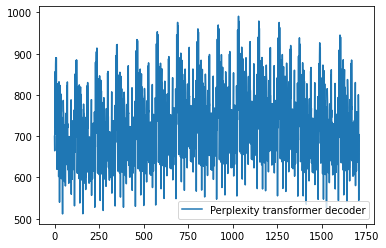

In [ ]:
plt.plot(perplexity_tr_decoder, label = 'Perplexity transformer decoder')
plt.legend()
plt.show()

zzz